# 1. Automatically scrape job postings of a competitor

We will now see scraping in action. Imagine you are working in HR for a major retailer. Your boss asks you to monitor the strategic hiring decisions of your close competitors. Naturally, you cannot go and call them up - but you could take a look at their job postings to see ($i$) how much they are hiring, ($ii$) what types of positions they are hiring for.

Now, you could log onto their website every day, see what job postings there are, compare that with the job postings from before, and save the relevant data. But why go through so much effort if we can just automate the task?

## 1.1 Using BeautifulSoup

The first example relies purely on what we have learned about BeautifulSoup and Requests (and a bit of Pandas!).

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

We are searching for positions in the head office of Aldi. Aldi has a dedicated website for these positions, "https://www.aldirecruitment.co.uk/head-office". We request the HTML document at this address and parse it with BeautifulSoup:

In [ ]:
url = "https://www.aldirecruitment.co.uk/head-office"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
print(soup)

We see that there are different types of head office positions, each with their own website. Let's get the links to those sub-sites.

To do so, we note the structure of HTML documents. Everything is embedded within tags, which confer meaning (e.g., "li" tags to signify list elements, or "div" tags to signify sections within the document). We focus on "a"-tags: all links in an HTML document (to other HTML documents) appear within those tags. Let's `.find()` ourselves an "a"-tag with BeautifulSoup:

In [ ]:
soup.find('a')

This returns the first tag in the HTML document. But we want to find all of them, so we use `.findAll()`.

In [ ]:
a_tags = soup.findAll('a')
a_tags

We see that there are a lot of tags. Importantly, the ones that actually link to other sites will contain something along the lines of `href="link"`. `href` is an attribute of the "a"-tag. In particular, it contains the link that you will follow when clicking on the HTML document where the "a"-tag is located. When we have found an HTML tag in BeautifulSoup, we can access its attributes with `.get("attribute_name")`. Now, we are ready to collect the links from the "a"-tags:

In [ ]:
links = []
for a in a_tags:
    links.append(a.get('href'))
print(links)

We want to get only the links to actual job postings, so we have to clean the results somewhat. First, we eliminate any link that is `None` (this is the link when the "a"-tag doesn't actually have an href attribute, as in the first case:

In [ ]:
new_links = []
for link in links:
    if link != None:
        new_links.append(link)
links = new_links
print(links)

Next, we have to find the links that we actually care fore (the links to the departments in which positions are posted). Analyzing the HTML document, we find that all these links start with "/head-office/". So let's only keep links that start like this:

In [ ]:
new_links = []
for link in links:
    if link.startswith('/head-office/'):
        new_links.append(link)
links = new_links
print(links)

A final correction: there is one link that refers to the website itself ('/head-office/'). We don't need to consider this one:

In [ ]:
new_links = []
for link in links:
    if link != '/head-office/':
        new_links.append(link)
links = new_links
print(links)

We can now put everything together:

In [ ]:
url = "https://www.aldirecruitment.co.uk/head-office"
page = requests.get(url)
soup = BeautifulSoup(page.content, "html.parser")
links = []
for link in soup.findAll('a'):
    new_link = link.get('href')
    if new_link != None and new_link.startswith('/head-office/') and new_link != '/head-office/':
        links.append(new_link)
print(links)

So how to we access the department websites now? The links we got are relative to the domain (https://www.aldirecruitment.co.uk). Hence, to access any one of the websites, we use a combination of this domain, together with the link we just extracted. For example:

In [ ]:
category_url = "https://www.aldirecruitment.co.uk" + links[0]
page = requests.get(category_url)
print("We are extracting the website " + category_url)
print("It contains the following HTML document:")
soup = BeautifulSoup(page.content, "html.parser")
print(soup)

We've made it to one of the subsites. Postings can be found throughout the site in little dropdown menus. So how to find the dropdown menus? This is where inspecting the HTML really comes in. When inspecting the dropdown windows, you will see something like this:
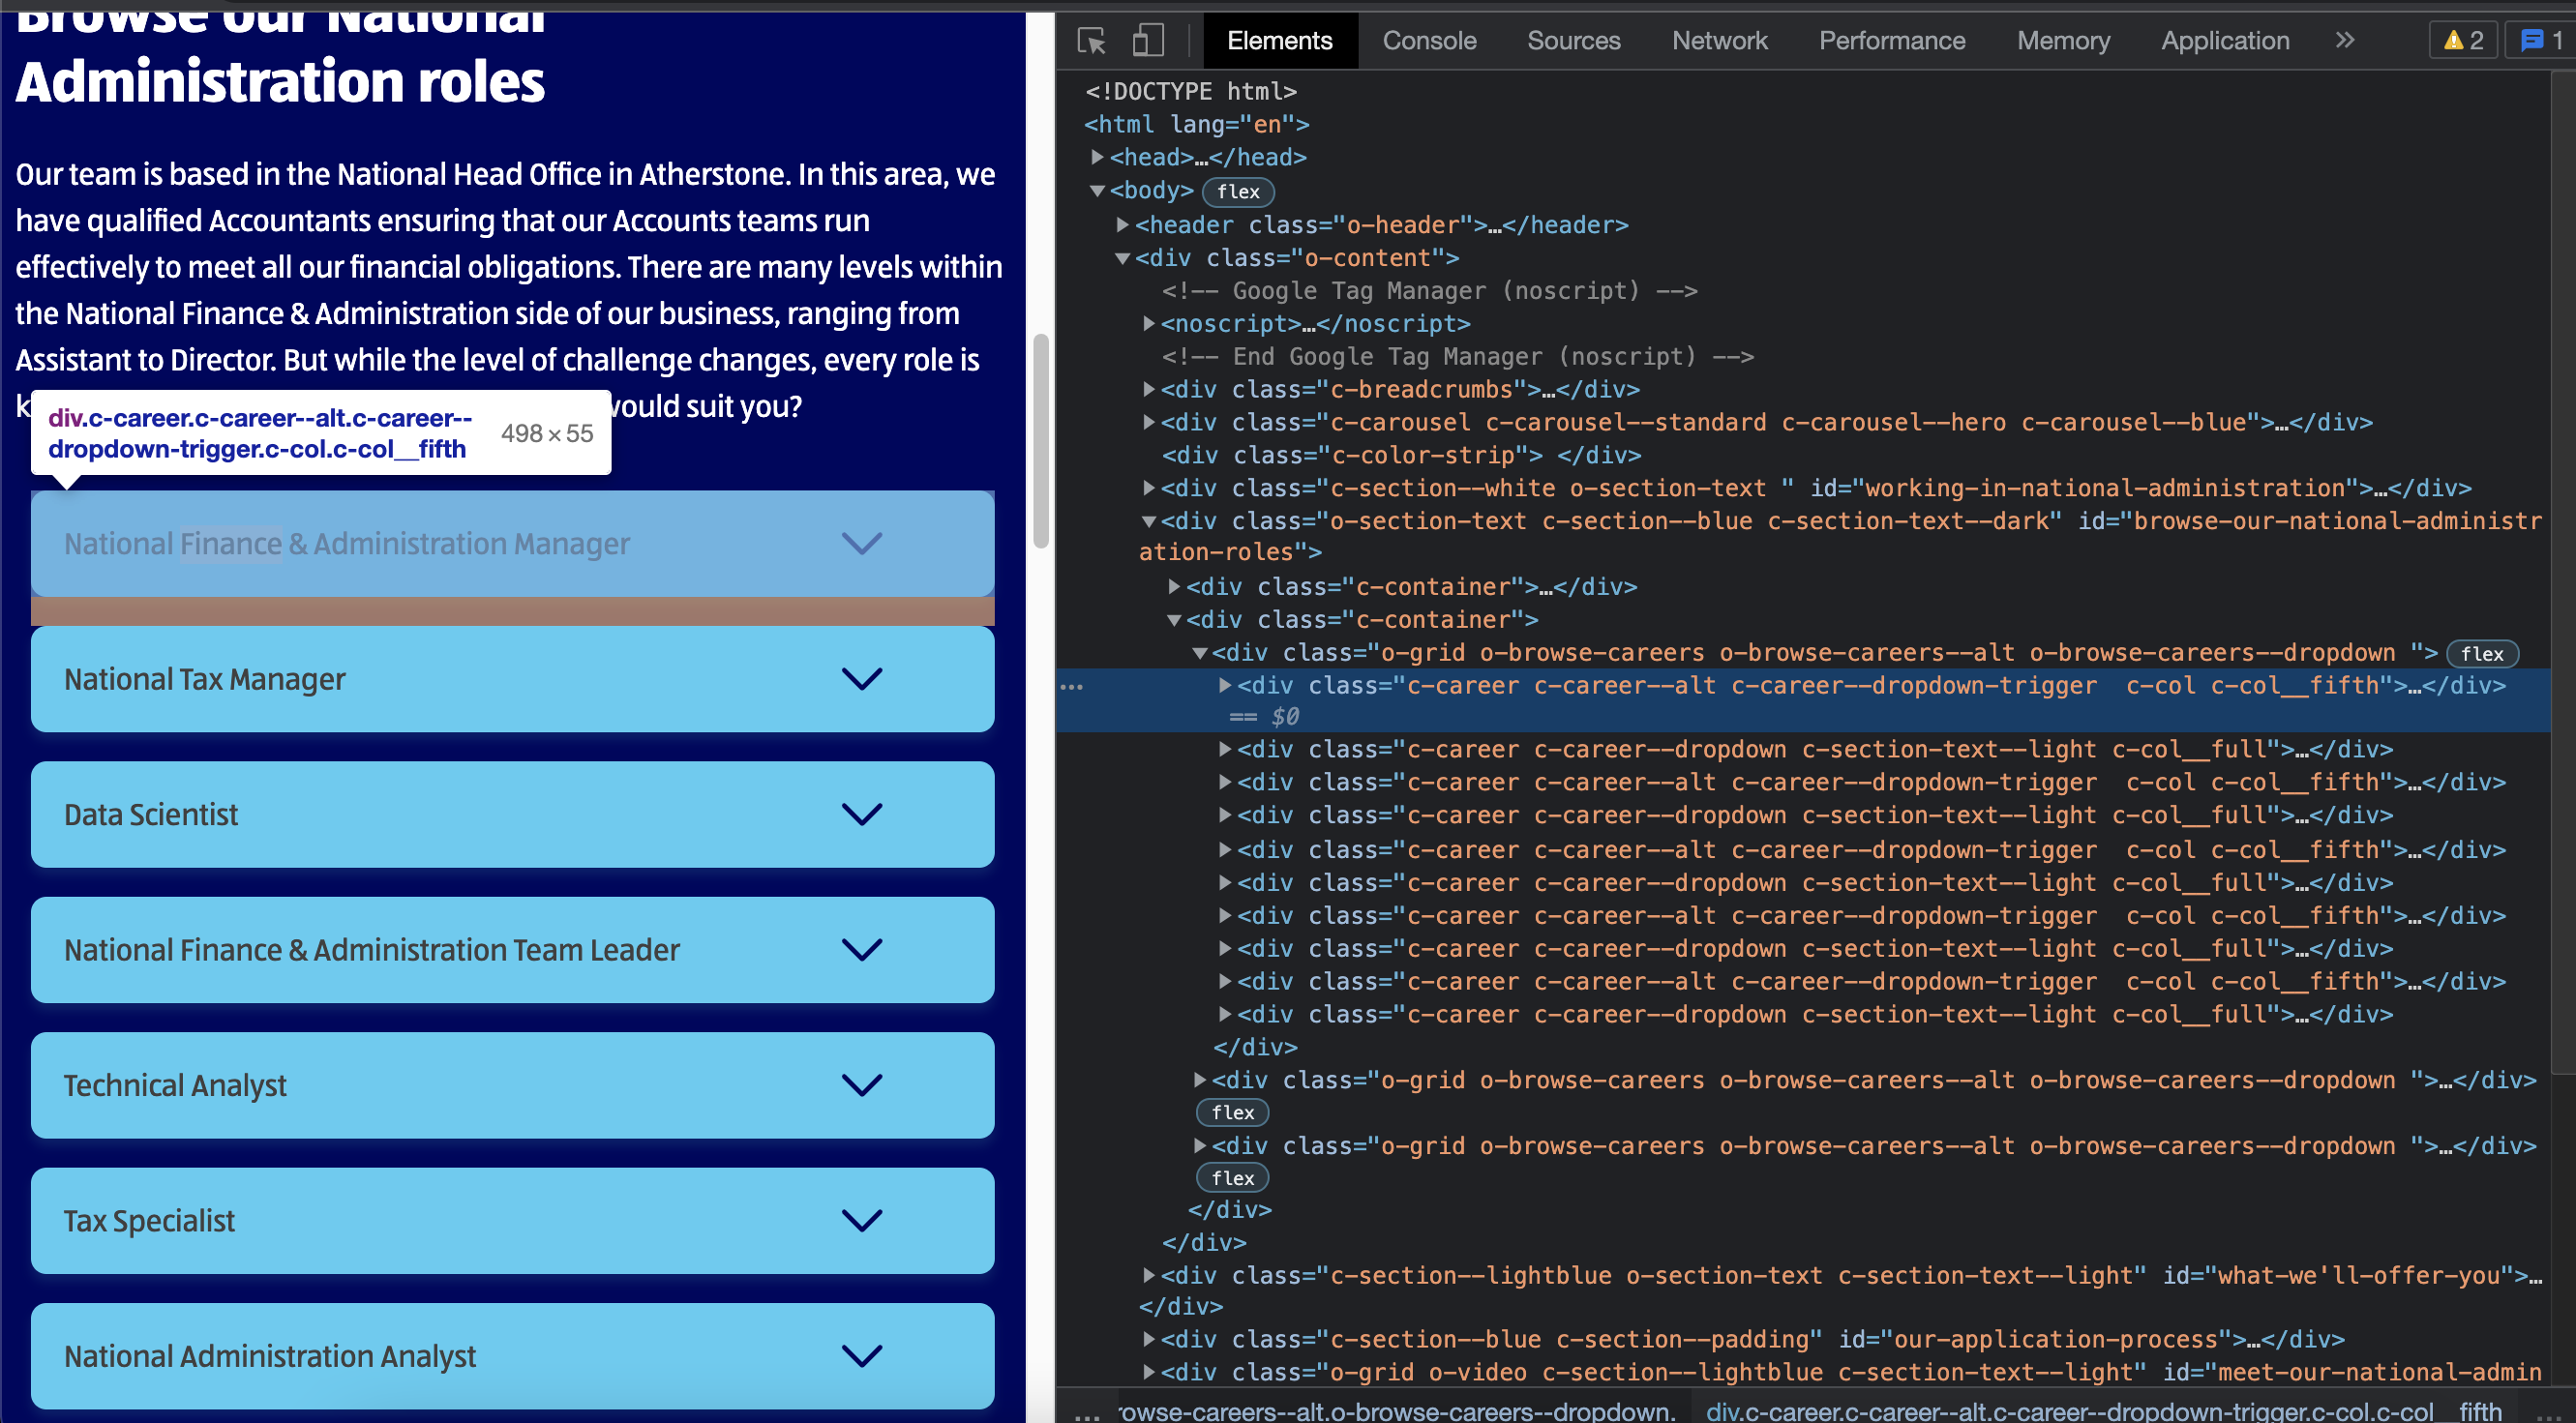

There are a bunch of "div" tags, that contain the relevant information. These tags list a class attribute (with multiple classes defined). We can make use of these attributes to find the right tags.

Take the first tag: it has the classes "c-career", "c-career--alt", "c-career--dropdown-trigger", "c-col", and "c-col__fifth". Note that the next tag has overlapping classes, but not exactly the same: "c-career", "c-career--dropdown", "c-section-text--light", and "c-col__full". What's the difference between these tags? Let's insepct and see:

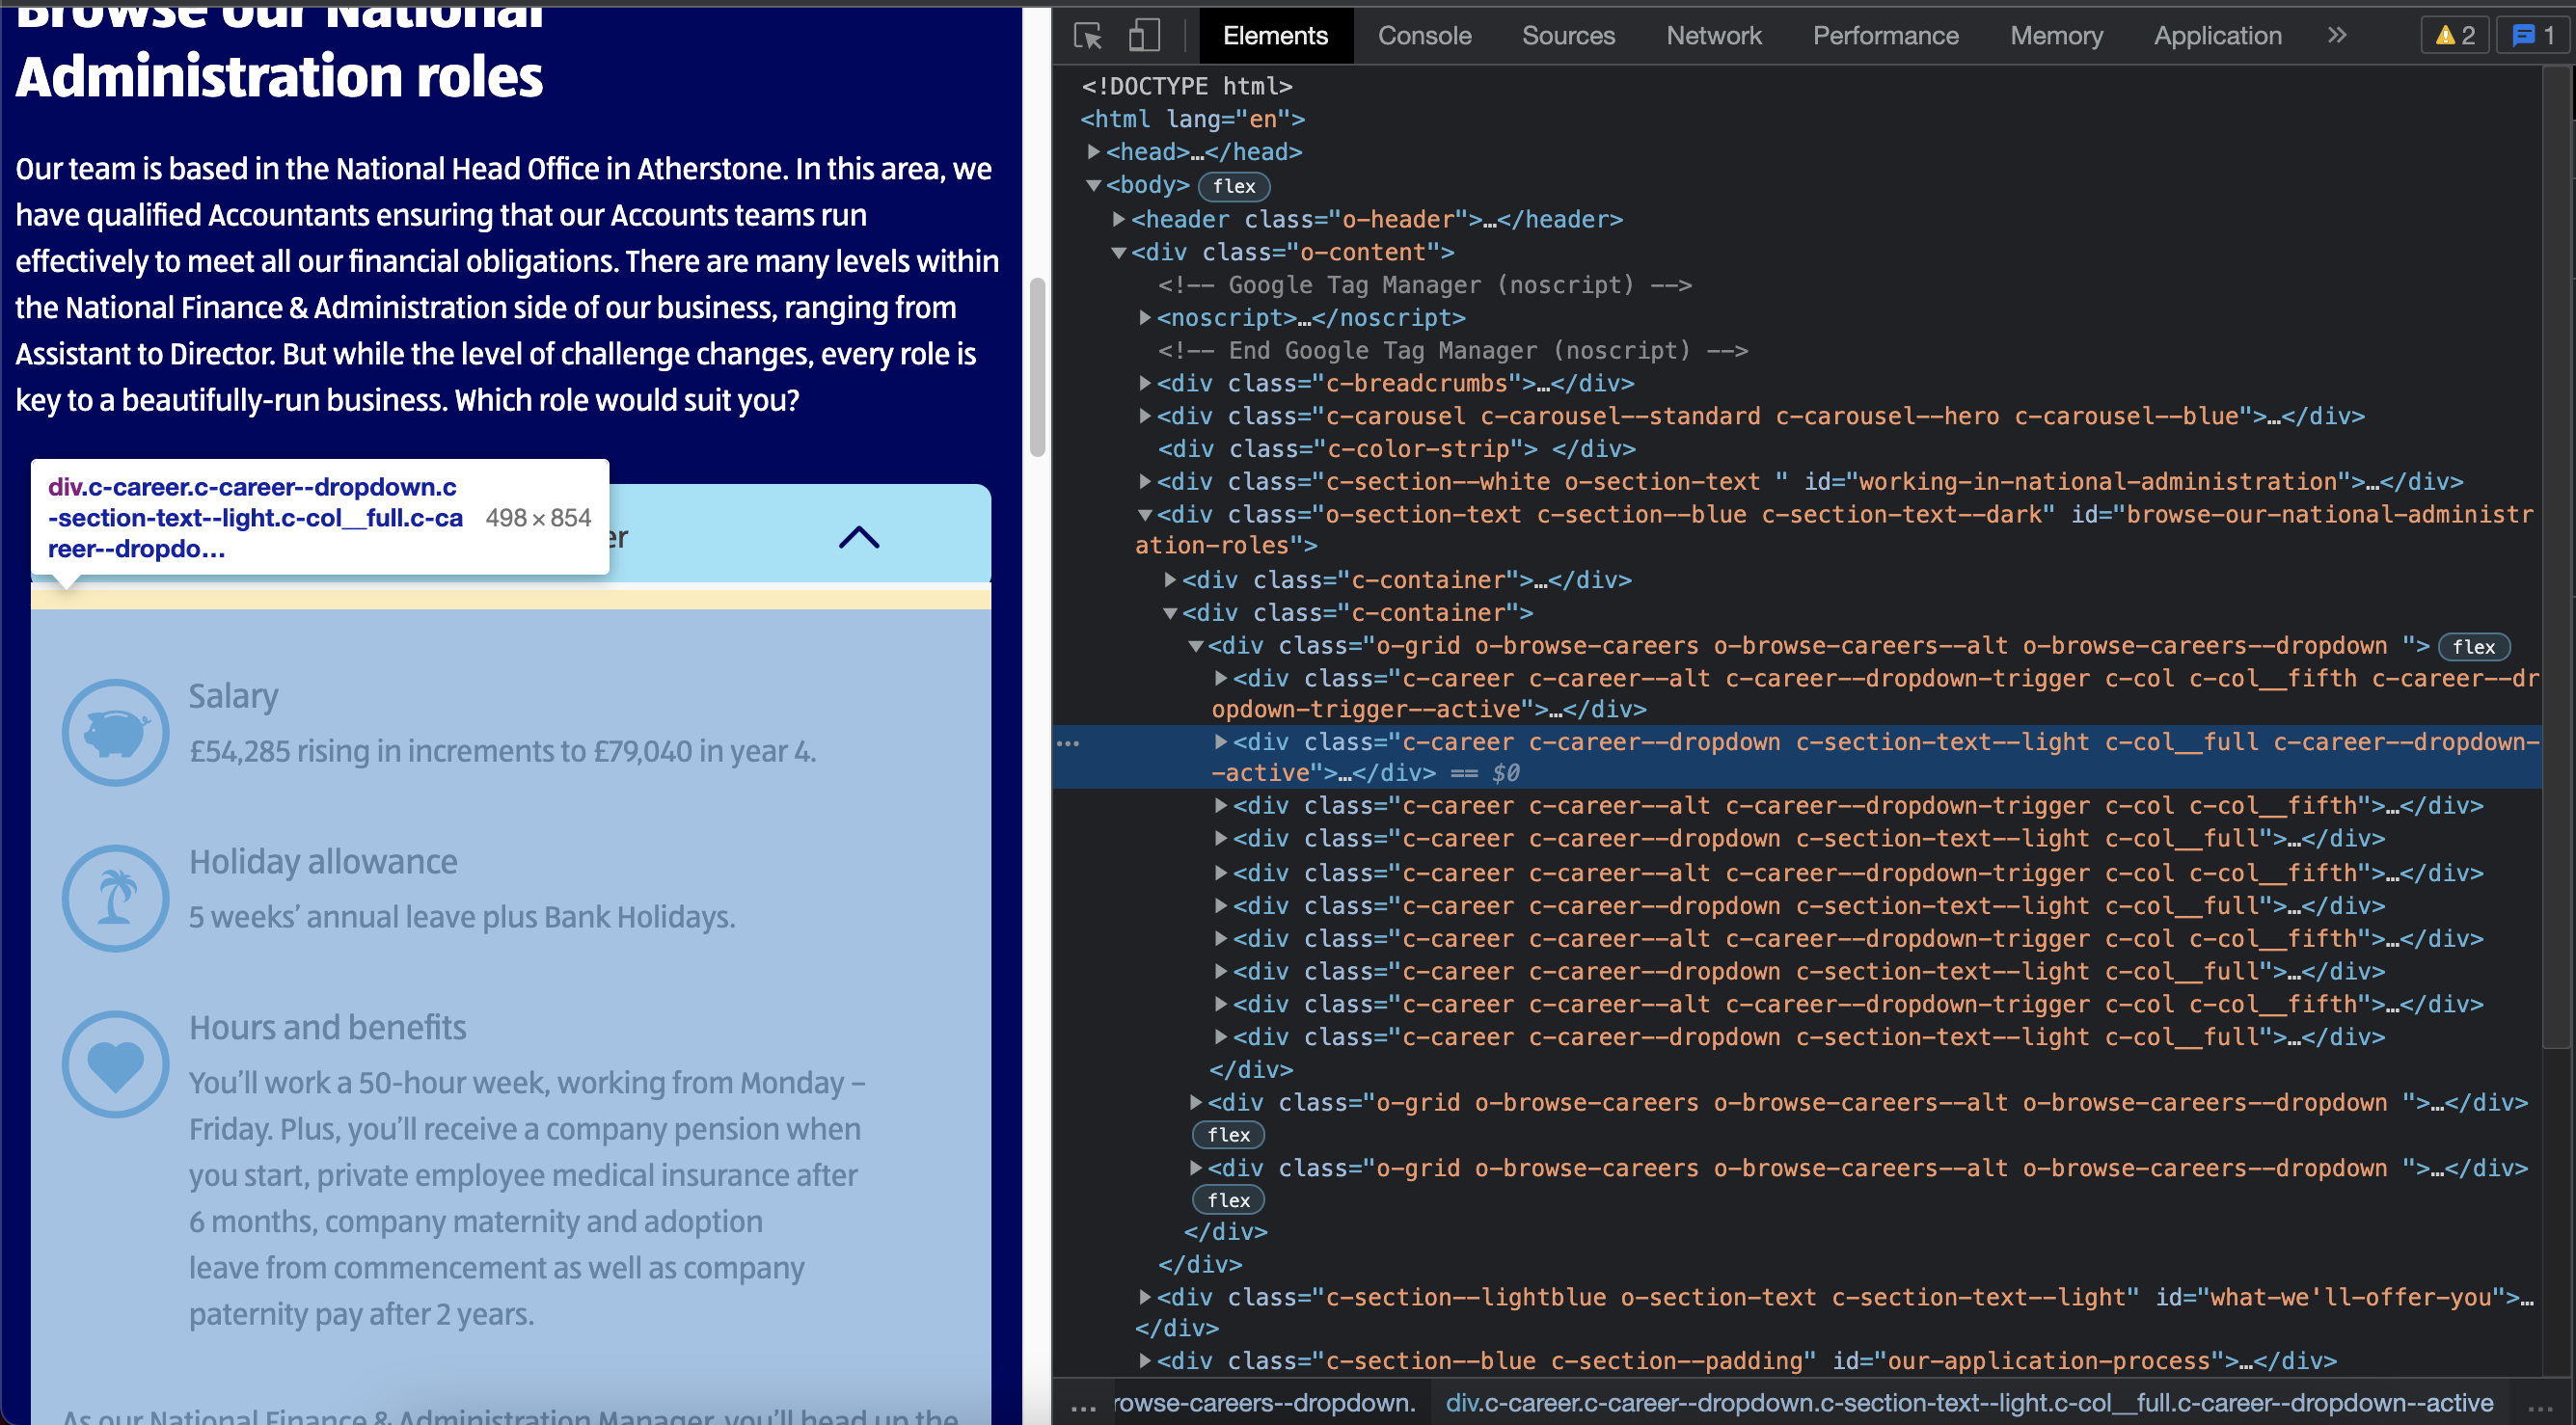

When we open the posting, we see that the second tag changes a little bit (it now also has the tag "c-career--dordown__active"). What we can find is that the relevant information is actually here (everything that gets dropped down). Luckily, the information is in the HTML even without opening the posting through clicking (open up the second tag to verify this!)

Playing with the inspection tool in this manner, we can soon see that the list of postings is structured as follows: one "div" tag that contains the heading on which you can click, and one "div" tag that contains the actual posting.

Now, of course, we could search for all the "div" tags with BeautifulSoup:

In [ ]:
div_tags = soup.findAll("div")
len(div_tags)

There are a lot of div tags, many more than postings. Luckily, we can use the different class attributes to specify our search. Let's start with the most obvious class, "c-career":

In [ ]:
div_tags = soup.findAll("div", class_="c-career")
len(div_tags)

There are still too many. Why? Because every posting comes with two sets of "div"-tags. So let's be more specific. The button-tag will always have class "c-career--dropwdown-trigger", but only the content tag will have "c-career--dropdown" (again, inspection is key:)

In [ ]:
div_tags = soup.findAll("div", class_="c-career--dropdown")
len(div_tags)

It seems we have found our posting! Let's verify:

In [ ]:
print(div_tags)

Of course, the actual information is still at lower layers. Let's focus on the first posting for now:

In [ ]:
posting = div_tags[0]
print(posting)

To find, for example, the job title, we can again use inspection. We see that the title is within a "h2"-tag, which is a type of header tag. Let's search this tag within the posting:

In [ ]:
posting.find('h2')

Note that we don't want to include the tags themselves, but only the text:

In [ ]:
posting.find('h2').text

Aside from the title and the text description (which we will ignore in this example, but which can hold extremely useful information), there are some key details about the job, such as the work time and the salary. The posting contains a little table. Again, we can use inspection to find what we are looking for.

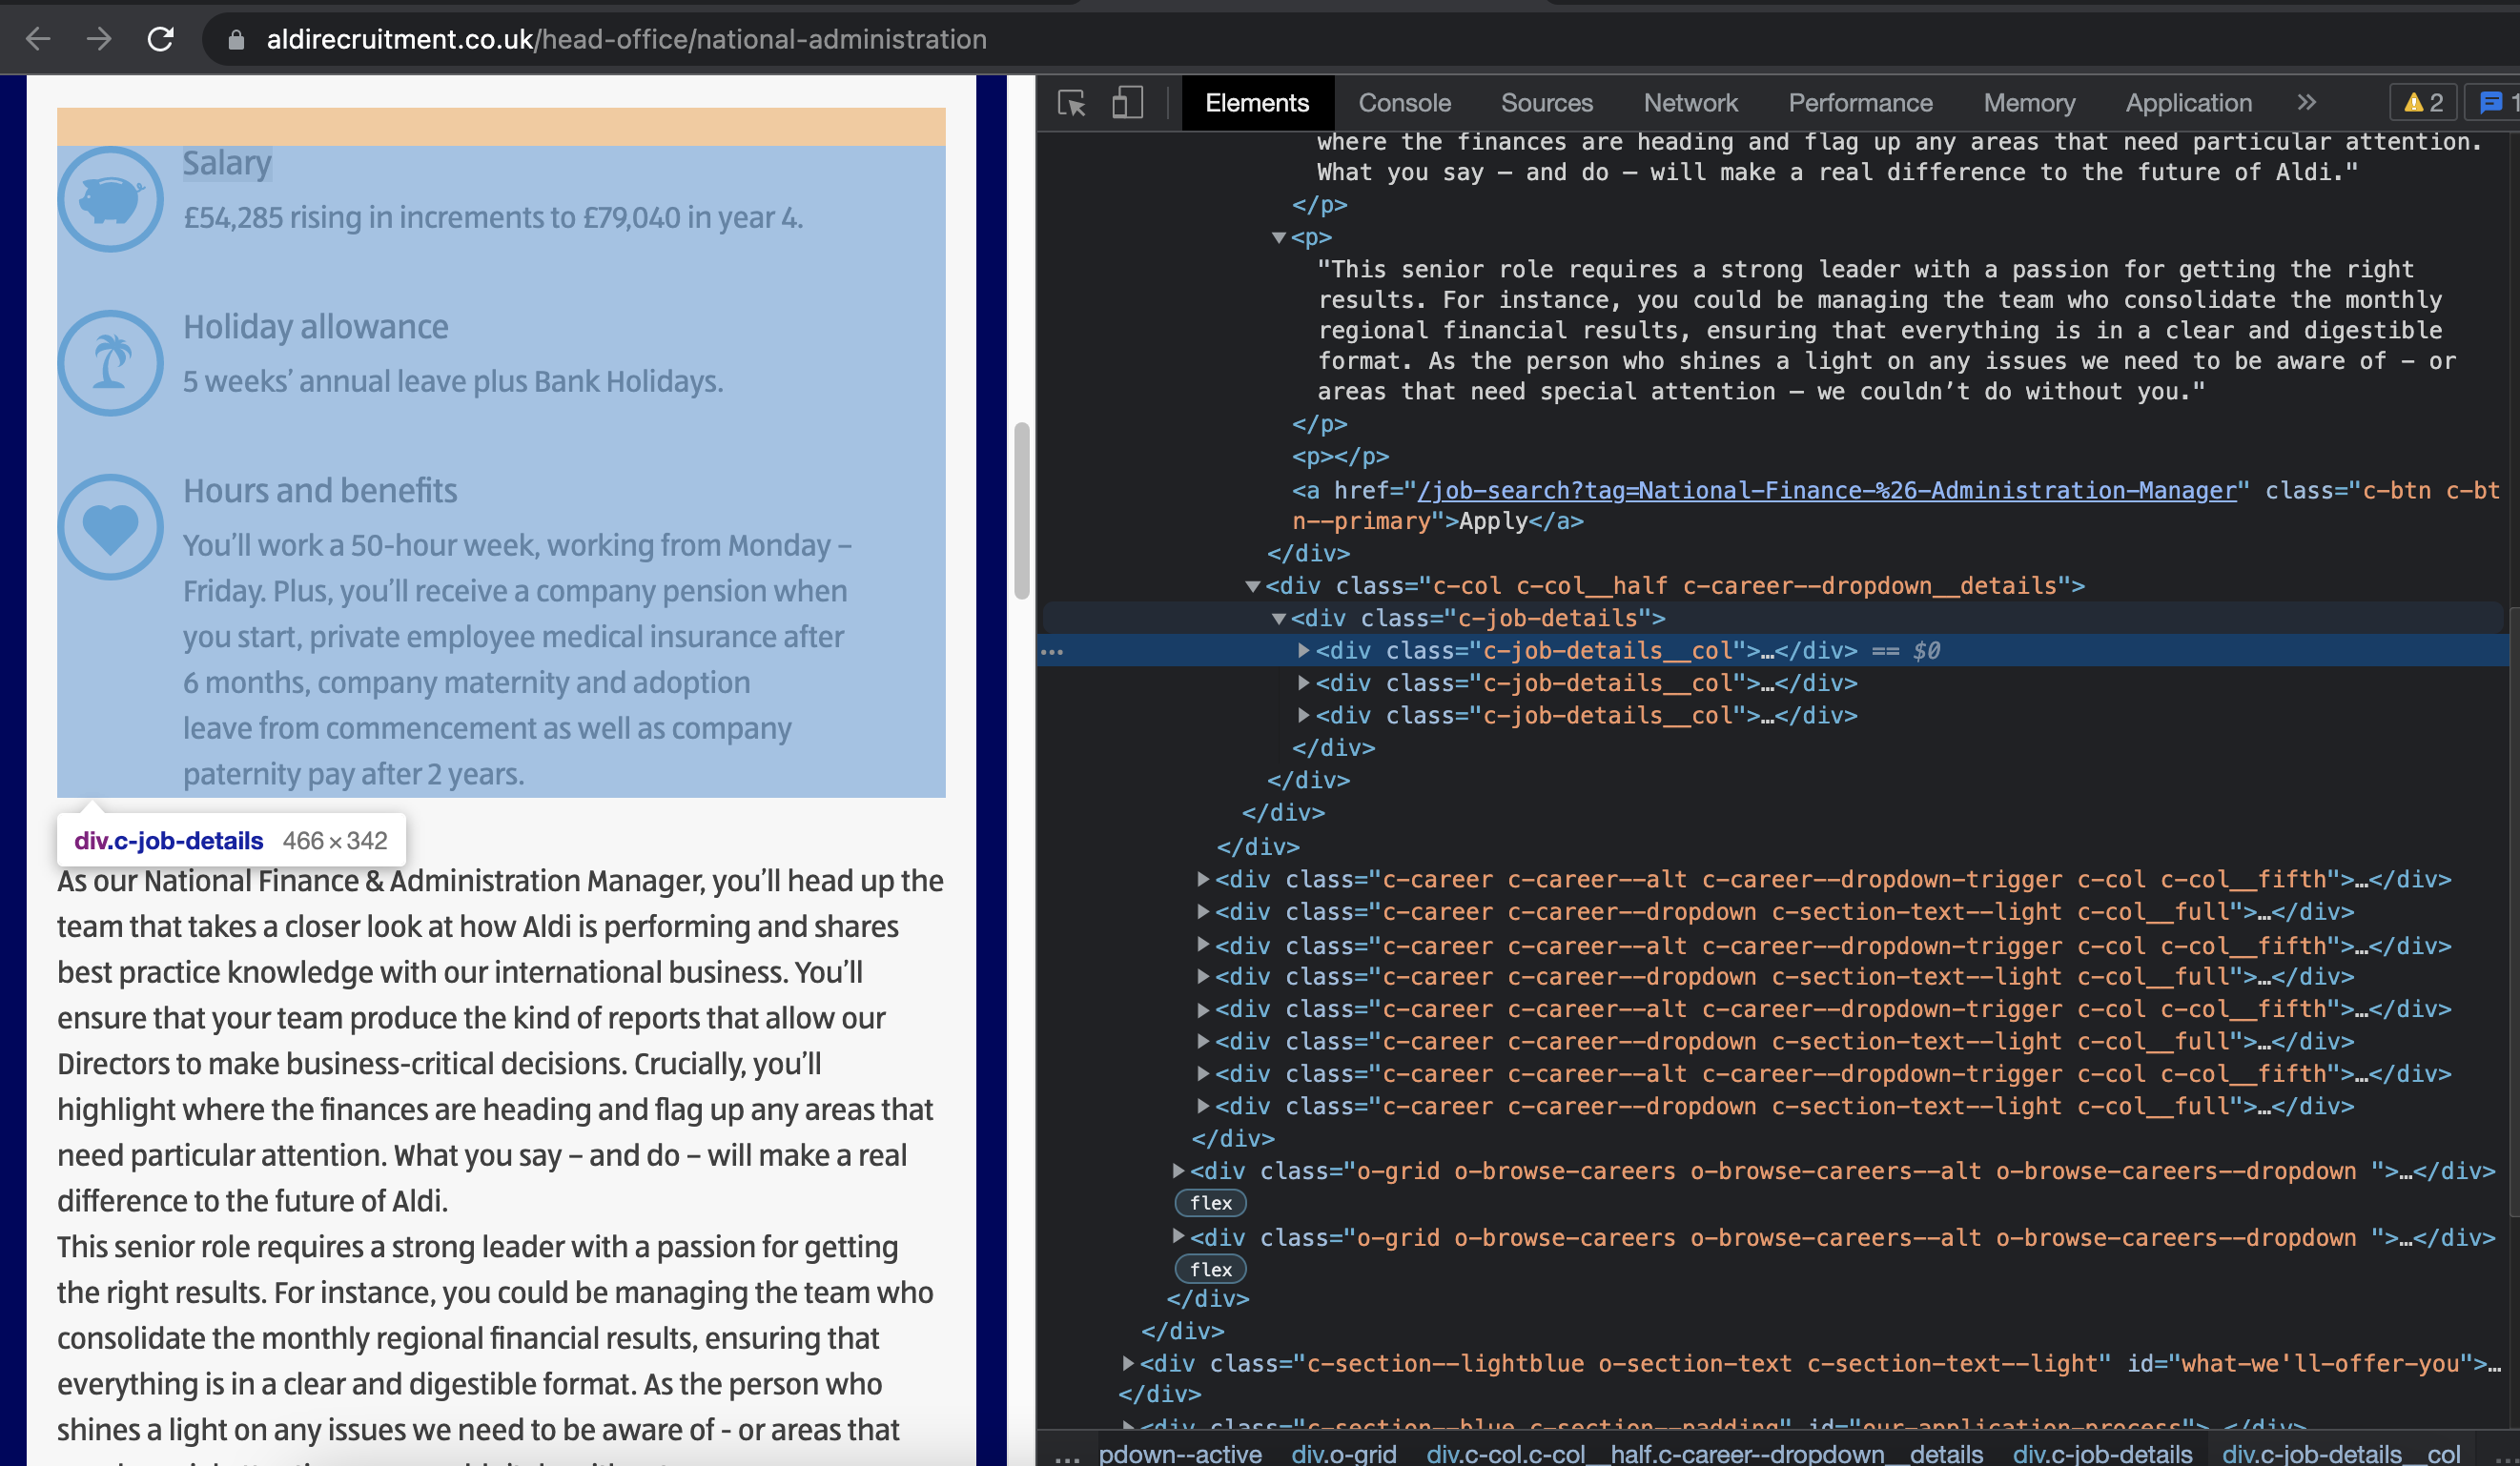

We see that the information here is contained in "div" tags of the class "c-job-details__col". In this case, there are three of these tags. Let's find them with BeautifulSoup:

In [ ]:
details = posting.findAll("div", class_="c-job-details__content")
print(details)

We definitely want to get the salary information. This is within the first tag, in another div tag. To identify that div tag, we again use the class: "c-job-details__text":

In [ ]:
salary_detail = details[0]
salary_text = salary_detail.find('div', class_="c-job-details__text").text
print(salary_text)

The text gives multiple values, so let's make sure to save the lowest and the highest value (of course, multiple values may be due to changes over time or for different starting requirements - we can adapt our scraper to capture arbitrary complexity later on). We start by splitting the sentence into words:

In [ ]:
word_list = salary_text.split()
print(word_list)

We now analyze whether we find any numbers here. Note that numbers start with the £-sign.

In [ ]:
number_content = [s for s in word_list if s.startswith('£')]
print(number_content)

Note the use of "," as a separator - we may not be able to convert the number with this. What we do is remove the £ sign and the comma, before converting the numbers to floats:

In [ ]:
numbers_formatted = []
for number in number_content:
    number = number.replace(',','')
    number = number.replace('£','')
    number = float(number)
    numbers_formatted.append(number)
print(numbers_formatted)

Now that we have the values as numbers, we can find the lower and the upper bound on the salary:

In [ ]:
ub = max(numbers_formatted)
lb = min(numbers_formatted)
print(ub)
print(lb)

We're done with salary. Let's also try to capture the weekly working hours. These are in the last job-detail div (and again, inside the div tag with class-attribute "c-job-details__text"):

In [ ]:
hour_detail = details[2]
hour_text = hour_detail.find('div', class_="c-job-details__text").text
print(hour_text)

The actual hours are indicated with "X-hour week". So let's find a string that looks like this (we first split the string into individual words):

In [ ]:
words = hour_text.split()
for word in words:
    if '-hour' in word:
        work_time = int(word.replace('-hour',''))
print(work_time)

The following code combines our extraction of job details in a function. We only adjust one aspect: instead for taking the first detail to be the salary and the third to be the hours, we actually check the title to see which one is which (this information is in a "span"-tag with class "c-jobs-details__title").

In [ ]:
def extract_posting_details(posting):
    job_title = posting.find('h2').text
    print("Scraping: " + job_title) # To see where possible possible errors are, we add a print out
    details = posting.findAll("div", class_="c-job-details__content")
    for detail in details:
        detail_title = detail.find('span', class_="c-job-details__title").text
        detail_text = detail.find('div', class_="c-job-details__text").text
        if detail_title.lower() == 'salary': # To avoid issues with capitalization, we use lower case on the detail title
            word_list = detail_text.split()
            number_content = [s for s in word_list if s.startswith('£')]
            numbers_formatted = []
            for number in number_content:
                number = number.replace(',','')
                number = number.replace('£','')
                number = float(number)
                numbers_formatted.append(number)
            ub = max(numbers_formatted)
            lb = min(numbers_formatted)
        elif detail_title.lower() == 'hours and benefits':
            words = detail_text.split()
            for word in words:
                if '-hour' in word:
                    work_time = int(word.replace('-hour',''))
    return job_title, lb, ub, work_time

Let's try with the first posting:

In [ ]:
posting = div_tags[0]
job_title, lb, ub, work_time = extract_posting_details(posting)

print(job_title)
print(ub)
print(lb)
print(work_time)

Let's now go through all postings on the subpage (if you get an error, this is normal!):

In [ ]:
i = 1
for posting in div_tags:
    print("Posting number " + str(i))
    job_title, lb, ub, work_time = extract_posting_details(posting)
    print("Job title: " + str(job_title))
    print("Salary upper bound: " + str(ub))
    print("Salary lower bound: " + str(lb))
    print("Work time: " + str(work_time))
    print("-----")
    i += 1

Where is the error coming from? There are cases without a number of hours or salary values. We adjust our code to make sure there is no error:

In [ ]:
def extract_posting_details(posting):
    job_title = posting.find('h2').text
    print("Scraping: " + job_title)
    details = posting.findAll("div", class_="c-job-details__content")
    ub = "not found" # Ensure that, even if the salary is not found, something is returend
    lb = "not found" # Ensure that, even if the salary is not found, something is returend
    work_time = "not found" # Ensure that, even if the work hours are not found, something is returend
    for detail in details:
        detail_title = detail.find('span', class_="c-job-details__title").text
        detail_text = detail.find('div', class_="c-job-details__text").text
        if detail_title.lower() == 'salary': # To avoid issues with capitalization, we use lower case on the detail title
            word_list = detail_text.split()
            number_content = [s for s in word_list if s.startswith('£')]
            numbers_formatted = []
            for number in number_content:
                number = number.replace(',','')
                number = number.replace('£','')
                number = float(number)
                numbers_formatted.append(number)
            if len(numbers_formatted) > 0: # We can only find a max and min salary if any numbers have been found
                ub = max(numbers_formatted)
                lb = min(numbers_formatted)
        elif detail_title.lower() == 'hours and benefits':
            words = detail_text.split()
            for word in words:
                if '-hour' in word:
                    work_time = int(word.replace('-hour',''))
    return job_title, lb, ub, work_time

Let's try again:

In [ ]:
i = 1
for posting in div_tags:
    print("Posting number " + str(i))
    job_title, lb, ub, work_time = extract_posting_details(posting)
    print("Job title: " + str(job_title))
    print("Salary upper bound: " + str(ub))
    print("Salary lower bound: " + str(lb))
    print("Work time: " + str(work_time))
    print("-----")
    i += 1

Now that we have all the information from one page, let's collect the information from all the subpages. To do so, we create another function, that iterates through all the pages, and all the postings within the pages:

In [ ]:
def scrape_aldi_headoffice_jobs():
    # We create lists of all the posting information we care about
    departments = []
    titles = []
    ubs = []
    lbs = []
    times = []
    
    # Start by getting all the urls of the subpages
    url = "https://www.aldirecruitment.co.uk/head-office/"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    links = []
    for link in soup.findAll('a'):
        new_link = link.get('href')
        if new_link != None and new_link.startswith('/head-office/') and new_link != '/head-office/':
            links.append(new_link)

    # Follow each of the subpage links
    for link in links:
        category_url = "https://www.aldirecruitment.co.uk" + link
        print("Scraping url: " + category_url) # We add another print-out to debug
        page = requests.get(category_url)
        # Parse the subpage
        soup = BeautifulSoup(page.content, "html.parser")
        
        # Find the name of the subpage (the links is the department name, which gives relevant information - we just need to clean it up a bit)
        # We simly take out the "/head-office/" part and the final /, as well as any dashed in-between
        department = link.replace("/head-office/","")
        department = department.replace("/","")
        department = department.replace("-"," ")

        # Find all the "div"-tags with class-attribute "c-career--dropdown" (these are the job postings):
        div_tags = soup.findAll("div", class_="c-career--dropdown")
        
        # Parse each of the job postings, using our previous function:
        for posting in div_tags:
            job_title, lb, ub, work_time = extract_posting_details(posting)
            # We add these to our lists:
            titles.append(job_title)
            lbs.append(lb)
            ubs.append(ub)
            times.append(work_time)
            # We also add the department information
            departments.append(department)
            
    # Finally, we convert our information into a data frame:
    job_data = pd.DataFrame(
        {'Department': departments,
         'Job title': titles,
         'Salary lower': lbs,
         'Salary upper': ubs,
         'Weekly hours': times
        })
    return job_data

Let's try it out (again, don't be surprised if there is an error here)

In [ ]:
aldi_job_data = scrape_aldi_headoffice_jobs()

Depending on when you scrape this, you might observe different errors. We will look at fixing those by redefining our extraction function. At the time of writing, I find the following issues:

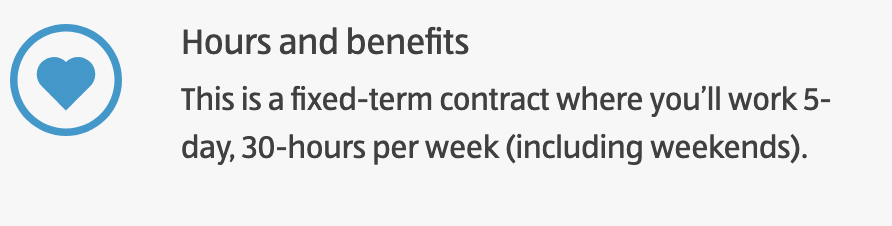
Here, it is "-hours" instead of "-hour"

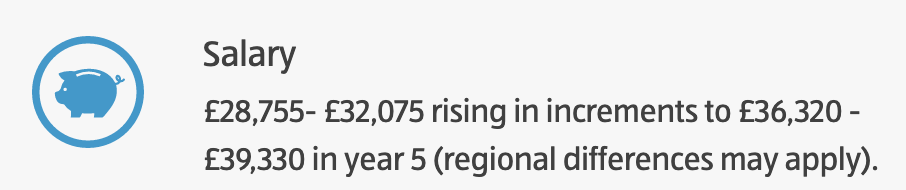
Here, there is a "-" directly attached to one of the numbers

Let's redefine our extraction function to take care of this (look for the comments to see the changes!):

In [ ]:
def extract_posting_details(posting):
    job_title = posting.find('h2').text
    print("Scraping: " + job_title)
    details = posting.findAll("div", class_="c-job-details__content")
    ub = "not found"
    lb = "not found"
    work_time = "not found"
    for detail in details:
        detail_title = detail.find('span', class_="c-job-details__title").text
        detail_text = detail.find('div', class_="c-job-details__text").text
        if detail_title.lower() == 'salary':
            word_list = detail_text.split()
            number_content = [s for s in word_list if s.startswith('£')]
            numbers_formatted = []
            for number in number_content:
                number = number.replace(',','')
                number = number.replace('-','') # In some cases, the salary is given as X-Y!
                number = number.replace('£','')
                number = float(number)
                numbers_formatted.append(number)
            if len(numbers_formatted) > 0:
                ub = max(numbers_formatted)
                lb = min(numbers_formatted)
        elif detail_title.lower() == 'hours and benefits':
            words = detail_text.split()
            for word in words:
                if '-hour' in word or '-hours' in word: # Sometimes, it is spelled X-hours instead of X-hour per week
                    word = word.replace('-hours','')
                    word = word.replace('-hour','')
                    work_time = int(word)
    return job_title, lb, ub, work_time

Now we can scrape with more confidence:

In [ ]:
aldi_job_data = scrape_aldi_headoffice_jobs()

And also see our results:

In [ ]:
aldi_job_data

We can now explore the data frame, improve our code if we find issues, and then analyze it. For example, let's have a look at a simple histogram of postings per department.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(30, 10)
sns.histplot(data=aldi_job_data, x="Department",ax=ax)
plt.show()

Finally, save the job postings we found as a CSV:

In [ ]:
aldi_job_data.to_csv('Aldi_postings_2021-10-21.csv', index=False)

## Exercise 1

Can you correct the scraping function to avoid issues with the salary or weekly hour number? Define a new function `scrape_aldi_jobs_corrected`, in which you eliminate any issues you come across in the data.

Note that the below code fixes some issues, but not all. You have a chance to get back to this within your assignment.

Looking at the CSV, we see something strange in the salary numbers:

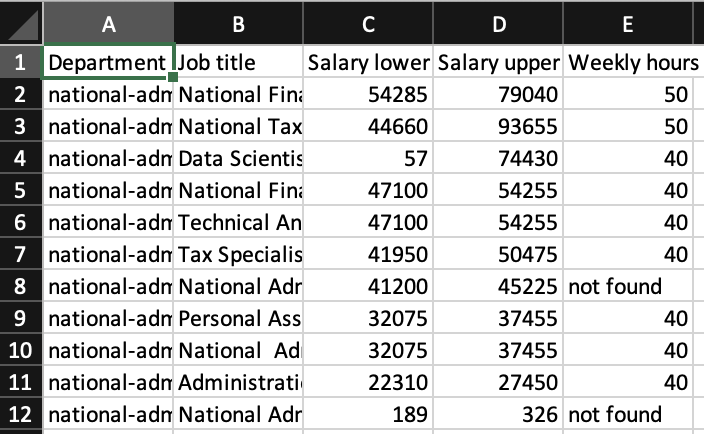

What is happening here? Looking at the postings in question, we immediately find the problem:

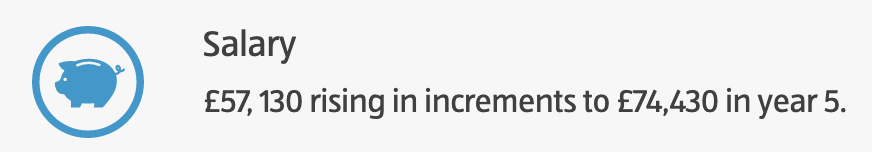
Here, there is a space after the thousands-comma.

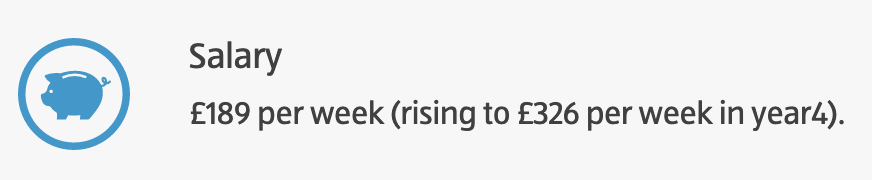
Here, there is a weekly salary.

Let's again redefine the parsing function:

In [ ]:
def extract_posting_details(posting):
    job_title = posting.find('h2').text
    print("Scraping: " + job_title)
    details = posting.findAll("div", class_="c-job-details__content")
    ub = "not found"
    lb = "not found"
    work_time = "not found"
    for detail in details:
        detail_title = detail.find('span', class_="c-job-details__title").text
        detail_text = detail.find('div', class_="c-job-details__text").text
        if detail_title.lower() == 'salary':
            word_list = detail_text.split()
            week_marker = False # We check whether the posting specifies the salary as "per week"
            if "per" in word_list and "week" in word_list:
                week_marker = True
            # We go through the list of words. If we find a word starting with £ and ending with , we add the following word to it
            number_content = []
            for index in range(len(word_list)):
                # Here, we check whether a word starts with £ and ends with ,
                if index < len(word_list) - 1 and word_list[index].startswith('£') and word_list[index].endswith(','):
                    number_content.append(word_list[index] + word_list[index+1])
                # If not, but the word still starts with £ we still add it
                elif word_list[index].startswith('£'):
                    number_content.append(word_list[index])
            numbers_formatted = []
            for number in number_content:
                number = number.replace(',','')
                number = number.replace('-','')
                number = number.replace('£','')
                number = float(number)
                numbers_formatted.append(number)
            if len(numbers_formatted) > 0:
                ub = max(numbers_formatted)
                lb = min(numbers_formatted)
                # If the salary was per week (week_marker), we adjust it accordingly
                if week_marker:
                    ub = ub * 52/12
                    lb = lb * 52/12
        elif detail_title.lower() == 'hours and benefits':
            words = detail_text.split()
            for word in words:
                if '-hour' in word or '-hours' in word:
                    word = word.replace('-hours','')
                    word = word.replace('-hour','')
                    work_time = int(word)
    return job_title, lb, ub, work_time

Let's run our scraping tool again, and take another look:

In [ ]:
aldi_job_data = scrape_aldi_headoffice_jobs()
aldi_job_data.to_csv('Aldi_postings_2021-10-21.csv', index=False)

We can identify another issue at the end of the table:
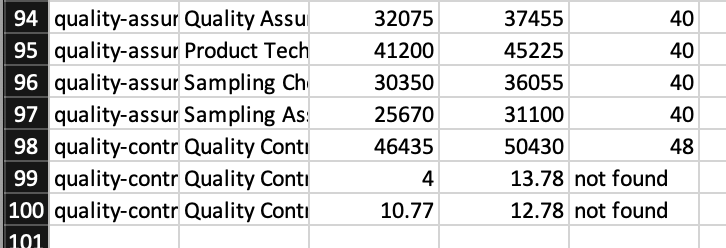

This is similar to before, just that the wages are now per hour:
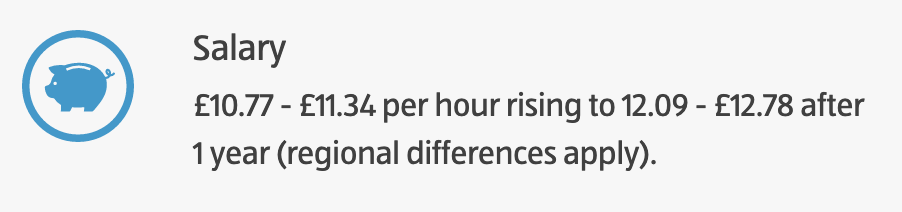

If we would simply assume 40 hours per week, we would get to weird salary comparisons. Here, we have to make sure that we actually compute the salary that someone obtains within a workweek with the given hours.

If we look at the postings, however, we see that the hours are not captured. This is because there is no dash in the hours:
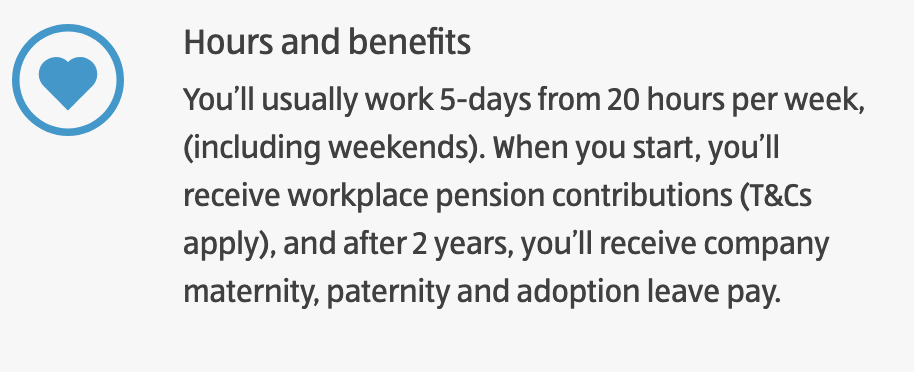

So, we need to also adjust the hour computation some more. Then, the tricky part is that we now need to combine salary and work hour information. As the sequence may be arbitrary, we need to make sure to do so outside of any of the particular parts:

In [ ]:
import re # We will use regular expressions to simplify our life below

def extract_posting_details(posting):
    job_title = posting.find('h2').text
    print("Scraping: " + job_title)
    details = posting.findAll("div", class_="c-job-details__content")
    ub = "not found"
    lb = "not found"
    work_time = "not found"
    hour_marker = False # We will use this to indicate if salary is hourly
    for detail in details:
        detail_title = detail.find('span', class_="c-job-details__title").text
        detail_text = detail.find('div', class_="c-job-details__text").text
        if detail_title.lower() == 'salary':
            word_list = detail_text.split()
            week_marker = False
            if "per" in word_list and "week" in word_list:
                week_marker = True
            # We now find out if the posting specifies an hourly salary
            if "per" in word_list and "hour" in word_list:
                hour_marker = True
            number_content = []
            for index in range(len(word_list)):
                if index < len(word_list) - 1 and word_list[index].startswith('£') and word_list[index].endswith(','):
                    number_content.append(word_list[index] + word_list[index+1])
                elif word_list[index].startswith('£'):
                    number_content.append(word_list[index])
            numbers_formatted = []
            for number in number_content:
                number = number.replace(',','')
                number = number.replace('-','')
                number = number.replace('£','')
                number = float(number)
                numbers_formatted.append(number)
            if len(numbers_formatted) > 0:
                ub = max(numbers_formatted)
                lb = min(numbers_formatted)
                if week_marker:
                    ub = ub * 52/12
                    lb = lb * 52/12                 
        elif detail_title.lower() == 'hours and benefits':
            words = detail_text.split()
            for word in words:
                if '-hour' in word or '-hours' in word:
                    word = word.replace('-hours','')
                    word = word.replace('-hour','')
                    work_time = int(word)
            # If the work_time could not be identified like this, we try finding a text such as "X hours".
            # This will actually be a lot easier using regular expressions (import is above)
            if not type(work_time) is int:
                times = re.findall('([0-9]+) hour',detail_text)
                if len(times) > 0:
                    work_time = int(times[0]) # For simplicity, we take the first value              
       
    # If the hour_marker is active (the posting gives salary per week), and we found both a salary value and a work_time, we adjust the salary values
    if hour_marker and (type(work_time) is int) and (type(ub) is float):
        ub = ub * work_time * 52
        lb = lb * work_time * 52
    return job_title, lb, ub, work_time

In [ ]:
aldi_job_data = scrape_aldi_headoffice_jobs()
aldi_job_data.to_csv('Aldi_postings_2021-10-21.csv', index=False)

## Exercise 2

The idea is that we run our code regularly and observe the current postings. For this, we need to do the following:
1. Load an existing csv file with job postings (on Moodle)
2. For any job currently found on the website, check whether it was already posted previously (focus on the department and title only)
3. Make sure you collect the date of posting as well

We start by importing the old job data:

In [ ]:
import numpy as np

old_job_data = pd.read_csv("Aldi_postings_2021-09-30.csv")
old_job_data.head()

We add a date of posting for the old data

In [ ]:
old_job_data[['Posted']] = "2021-09-30"
old_job_data.head()

We also add a posting data for the new data

In [ ]:
aldi_job_data[['Posted']] = "2021-10-14"
aldi_job_data.head()

We now pit the new data at the bottome of the data frame, below the old data:

In [ ]:
combined_data = pd.concat([old_job_data,aldi_job_data])
combined_data

We search for duplicates, but only within the columns Department and Job title, and drop them (this will automatically drop newer, repeated postings):

In [ ]:
combined_data.drop_duplicates(subset=['Department','Job title'])

## 1.2 A more advanced case - using Selenium to enter details

Let's get data from a second competitor. We will use Lidle here (I am, of course, not biased in my choices). Check out Lidl's hiring page https://careers.lidl.co.uk/ and start a search. Then look at the link where you landed at - can you see why things are a bit more complex here?

Since we cannot just find the right links, we need to act like a browser. This is where Selenium comes in - it will literally run a browser!

In [ ]:
import requests
from bs4 import BeautifulSoup
import selenium
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.keys import Keys
import pandas as pd
import re
import time

We need to choose the type of browser that Selenium runs - and each comes with its own access and installation requirements. I personally recommend using Chrome. However, to use Chrome, with Selenium, you need to install ChromeDriver. The site https://sites.google.com/chromium.org/driver/downloads gives download files, which should work fine for Windows users. Simply download and unpack the Zip, which gives you a .exe file. Either move it somewhere on your PATH, or add it to your path (https://stackoverflow.com/questions/4822400/register-an-exe-so-you-can-run-it-from-any-command-line-in-windows gives a good description how to).

On Mac, you may run into access issues. The easiest way to proceed is to use Homebrew (https://brew.sh/ shows how to use it). Once done, type
```
brew install chromedriver
```
into your terminal.
Other options can be found here: https://www.kenst.com/2015/03/installing-chromedriver-on-mac-osx/ (note that the syntax can be a bit outdated).

Once done, the below code will open a new window in the browser of your choice (here Chrome):

In [ ]:
driver = webdriver.Chrome()
driver.get("https://careers.lidl.co.uk/jobsearch")

You will notice that this is a completely new Chrome process - so cookies are not yet accepted. To see what's going on, let's start by accepting cookies. How do we do this? We simply find the right button and then let Selenium click this button!

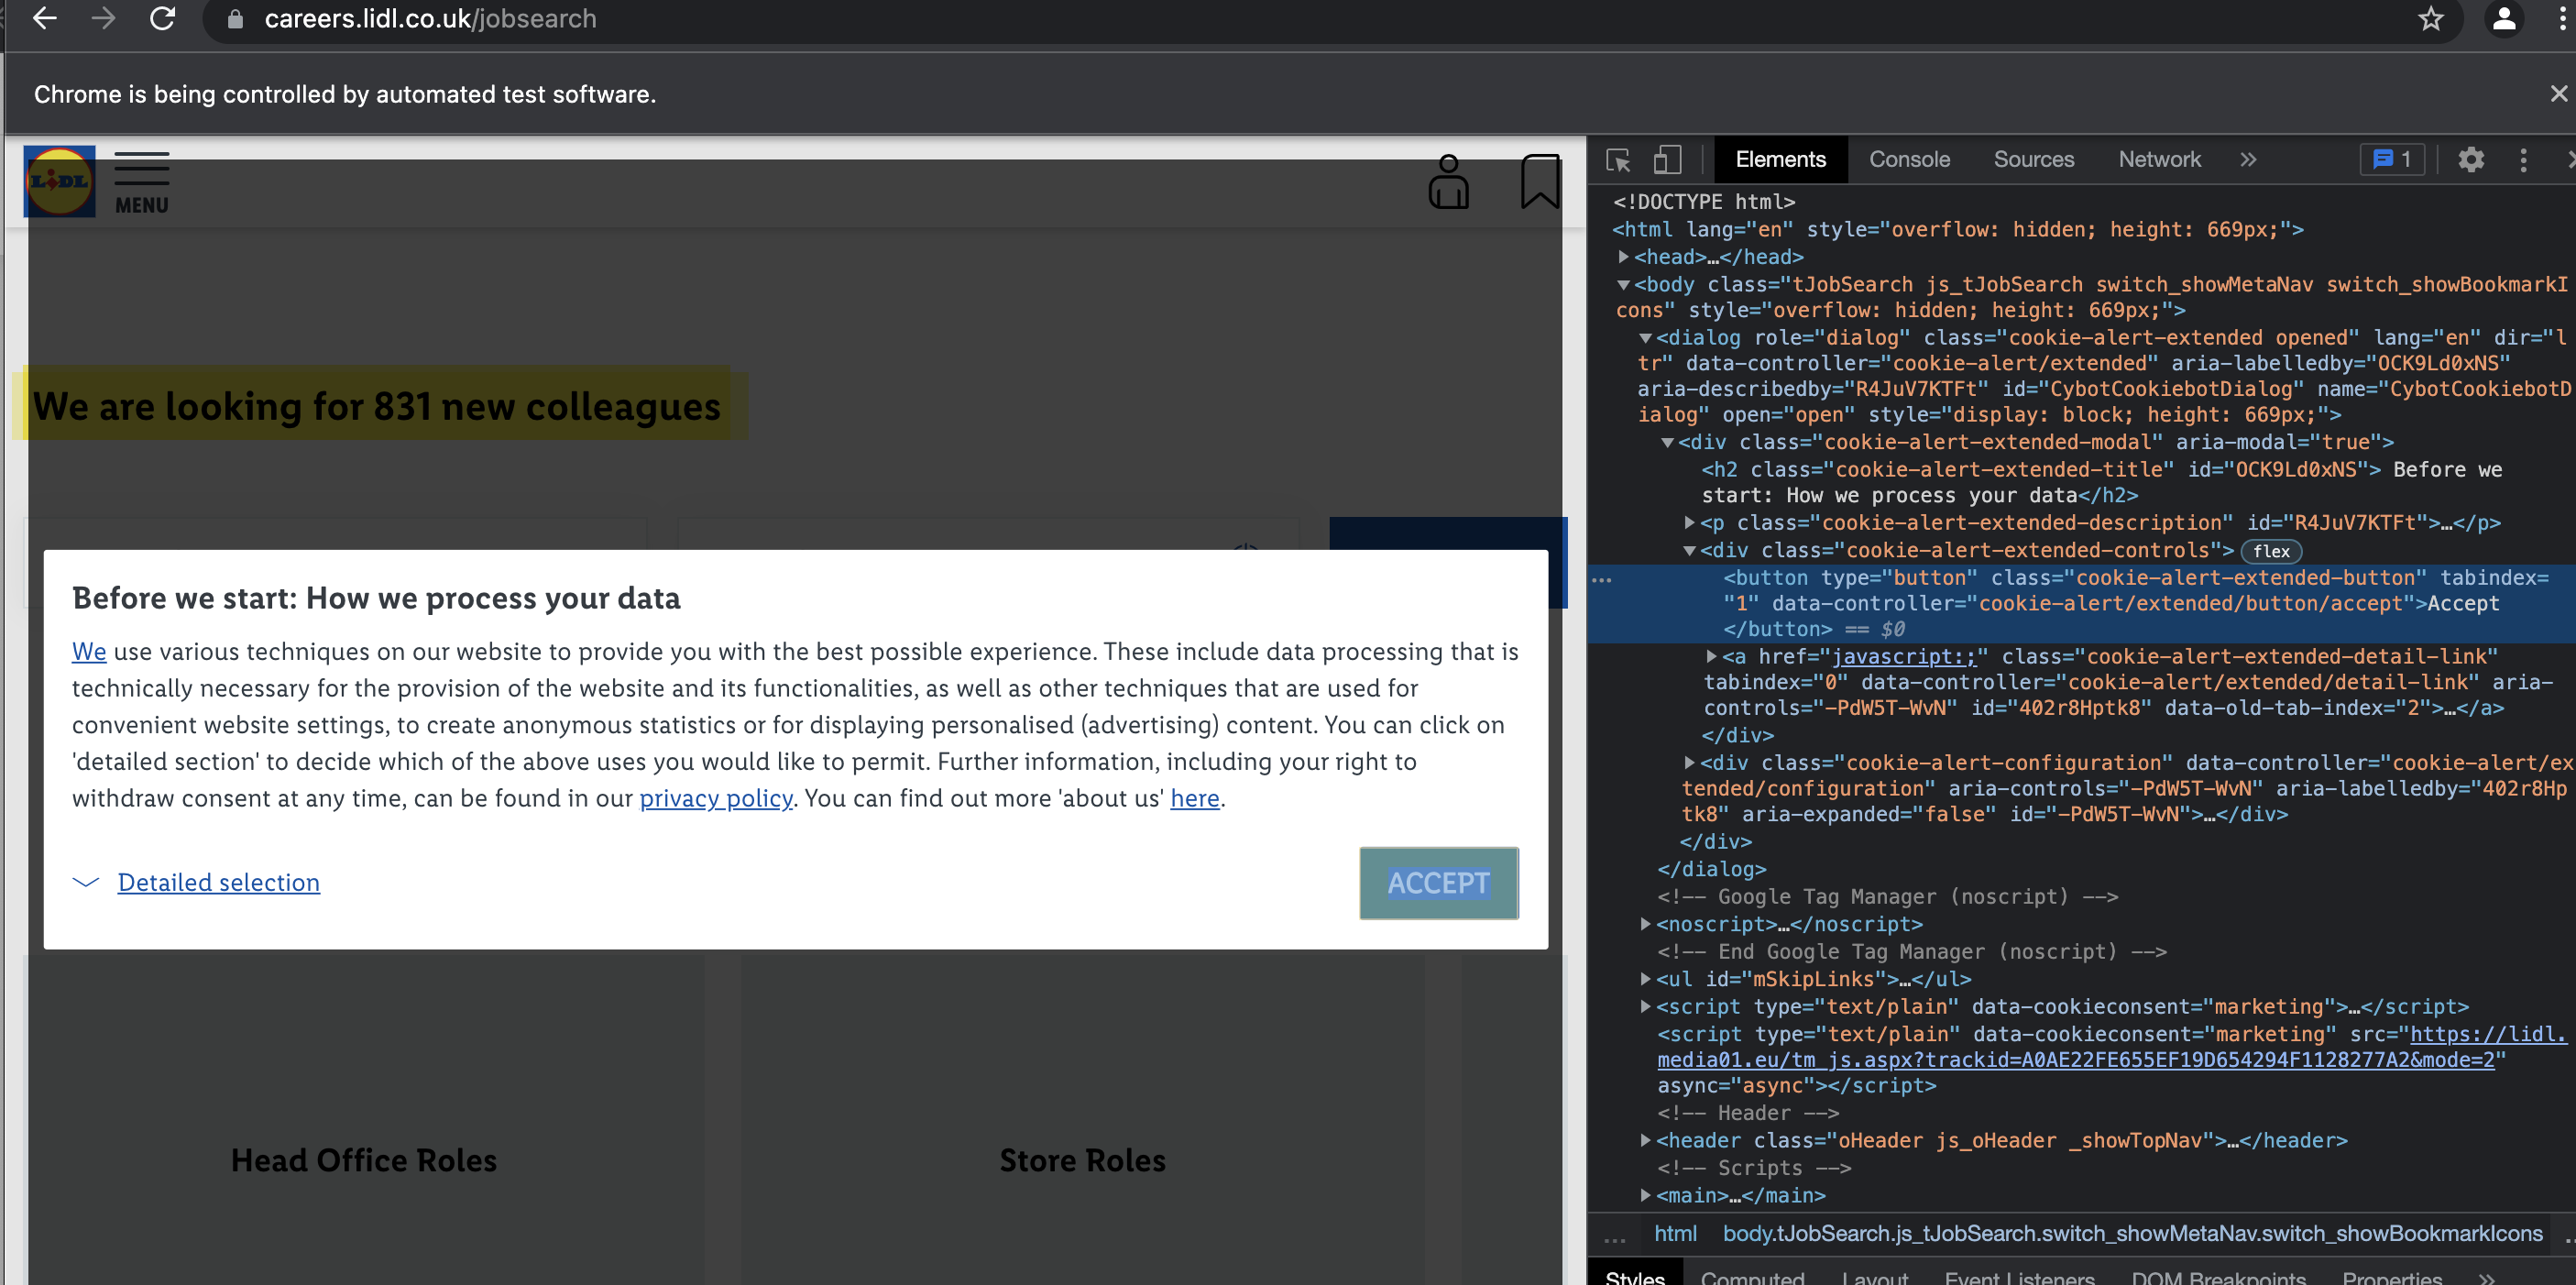

We use XPath to find the button. The structure is similar to what we did with BeautifulSoup (we have a "button"-tag with an attribute class, which takes the value "cookie-alert-extended-button"). We can find this element with its XPath: '//button[@class="cookie-alert-extended-button"]'
What does this mean? It means we look for any button-tag on the site that has an attribute class with the given content.
Once we found the button, we just click it:

In [ ]:
cookie_button = driver.find_element_by_xpath('//button[@class="cookie-alert-extended-button"]')
cookie_button.click()

Once cookies are accepted, the Lidl jobs site offers the option to select head office positions, just like Aldi. However, the link is relatively complex, so we will simply let Selenium click on the right button again.

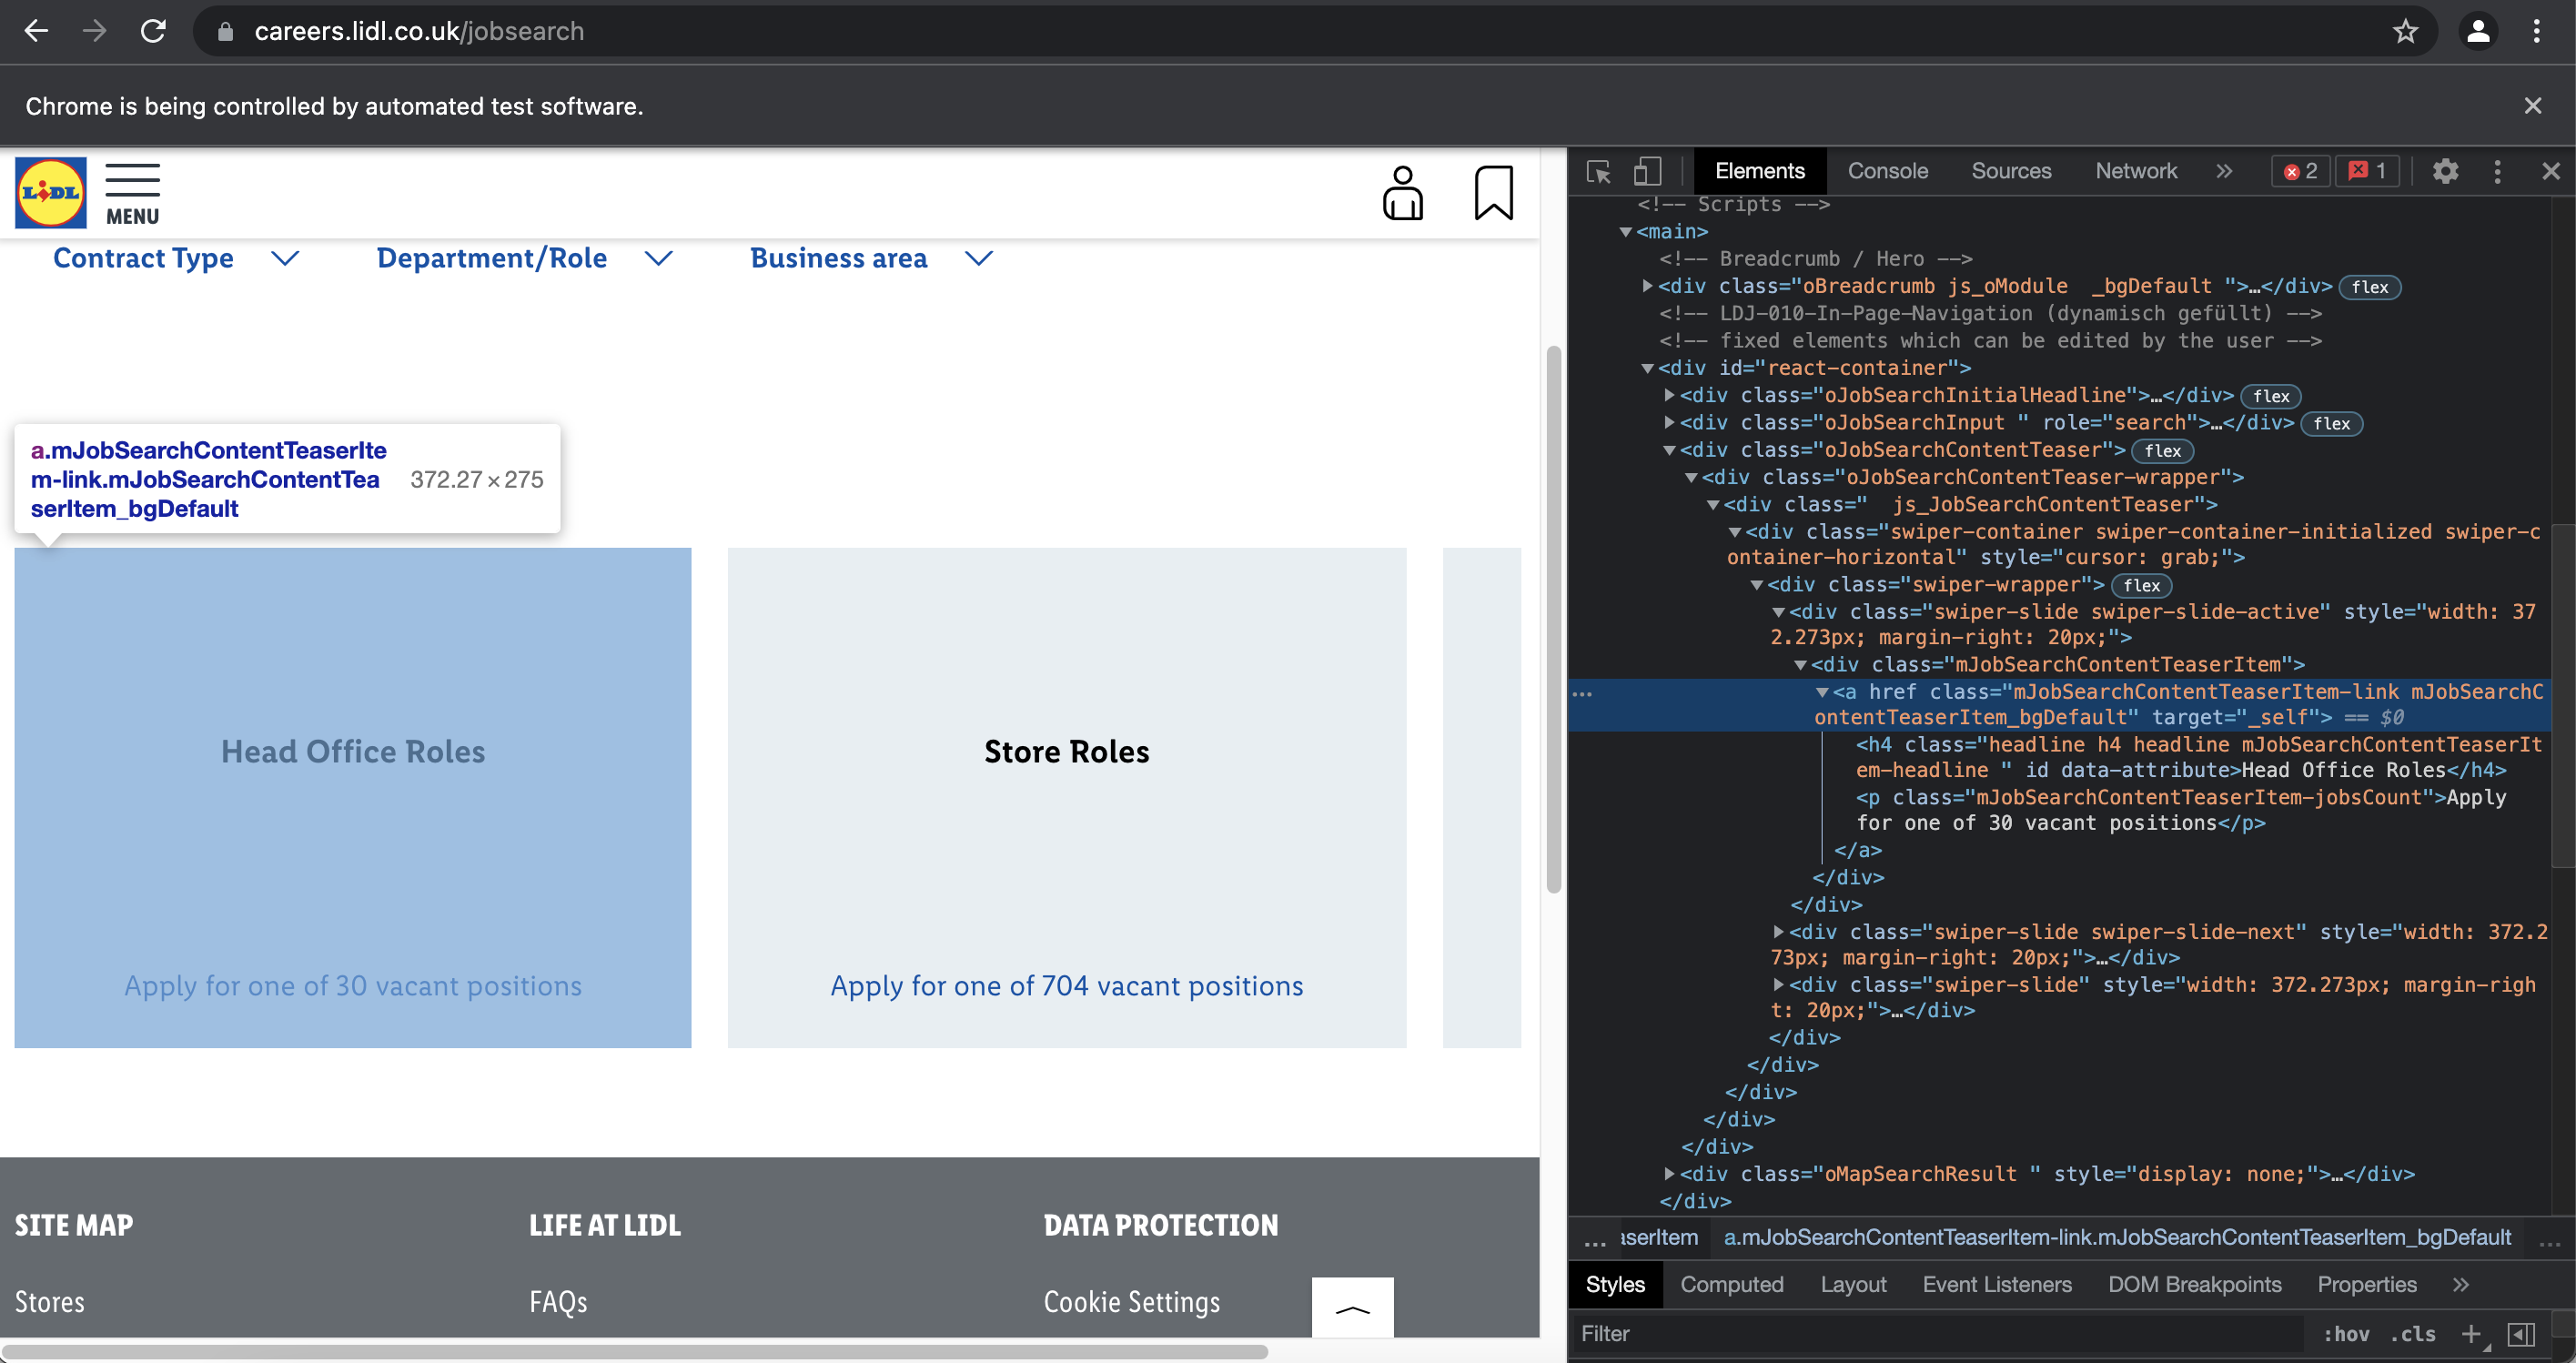

It's a bit less clear what element to use (there is nothing as obvious as "button"), but we could try the a-tag. The XPath this time is '//a[contains(@class,"mJobSearchContentTeaserItem-link")]': We are searching for an a-tag with a class attribute as given. Different from BeautifulSoup, classes separated by space won't be differentiated. Hence, we have to check whether the attribute class "contains" the keyword, instead of matching exactly. Let's try it out:

In [ ]:
head_office_button = driver.find_element_by_xpath('//a[contains(@class,"mJobSearchContentTeaserItem-link")]')
head_office_button.click()

There are a few positions here. If you click on any of those, you'll notice that the links are relatively simple in structure and don't depend on your website interaction. Hence, the easiest is for us to just collect all the posting links (and then use BeautifulSoup to analyze them individually as before).

We can see that postings come within a-tags with class "jobResult":
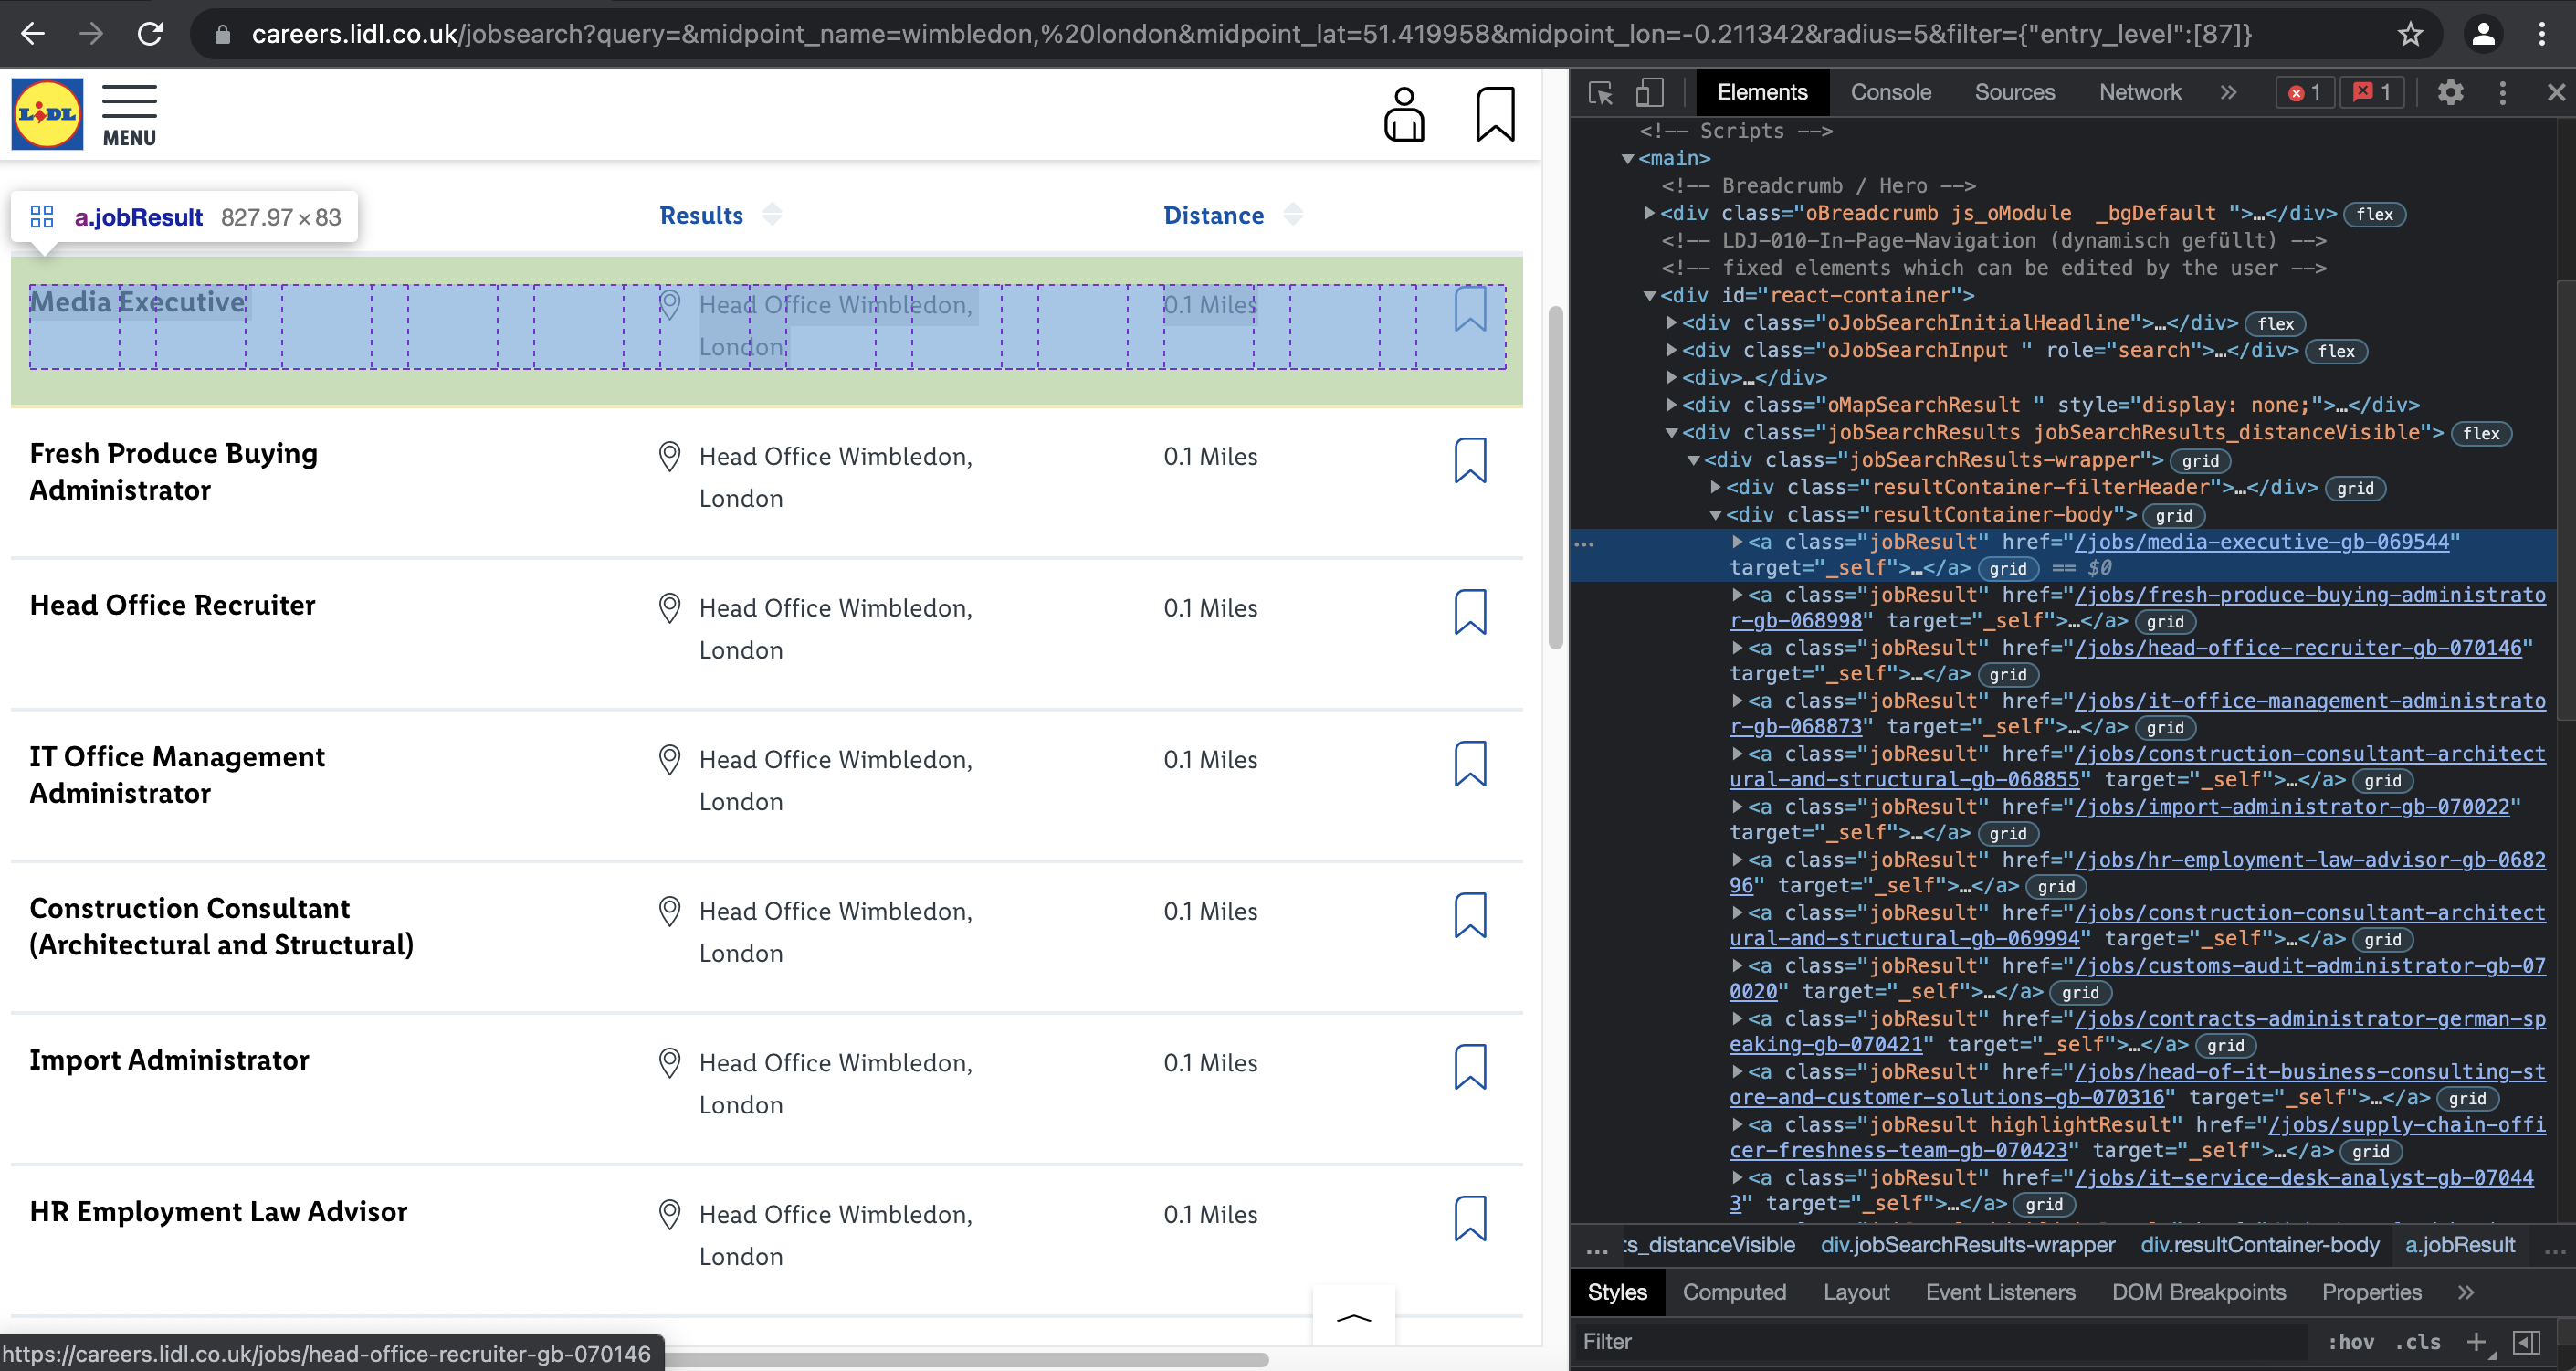

Again, we could use XPath to find the right tags: '//a[@class="jobResult"]'. However, some postings are highlighted and have two classes:

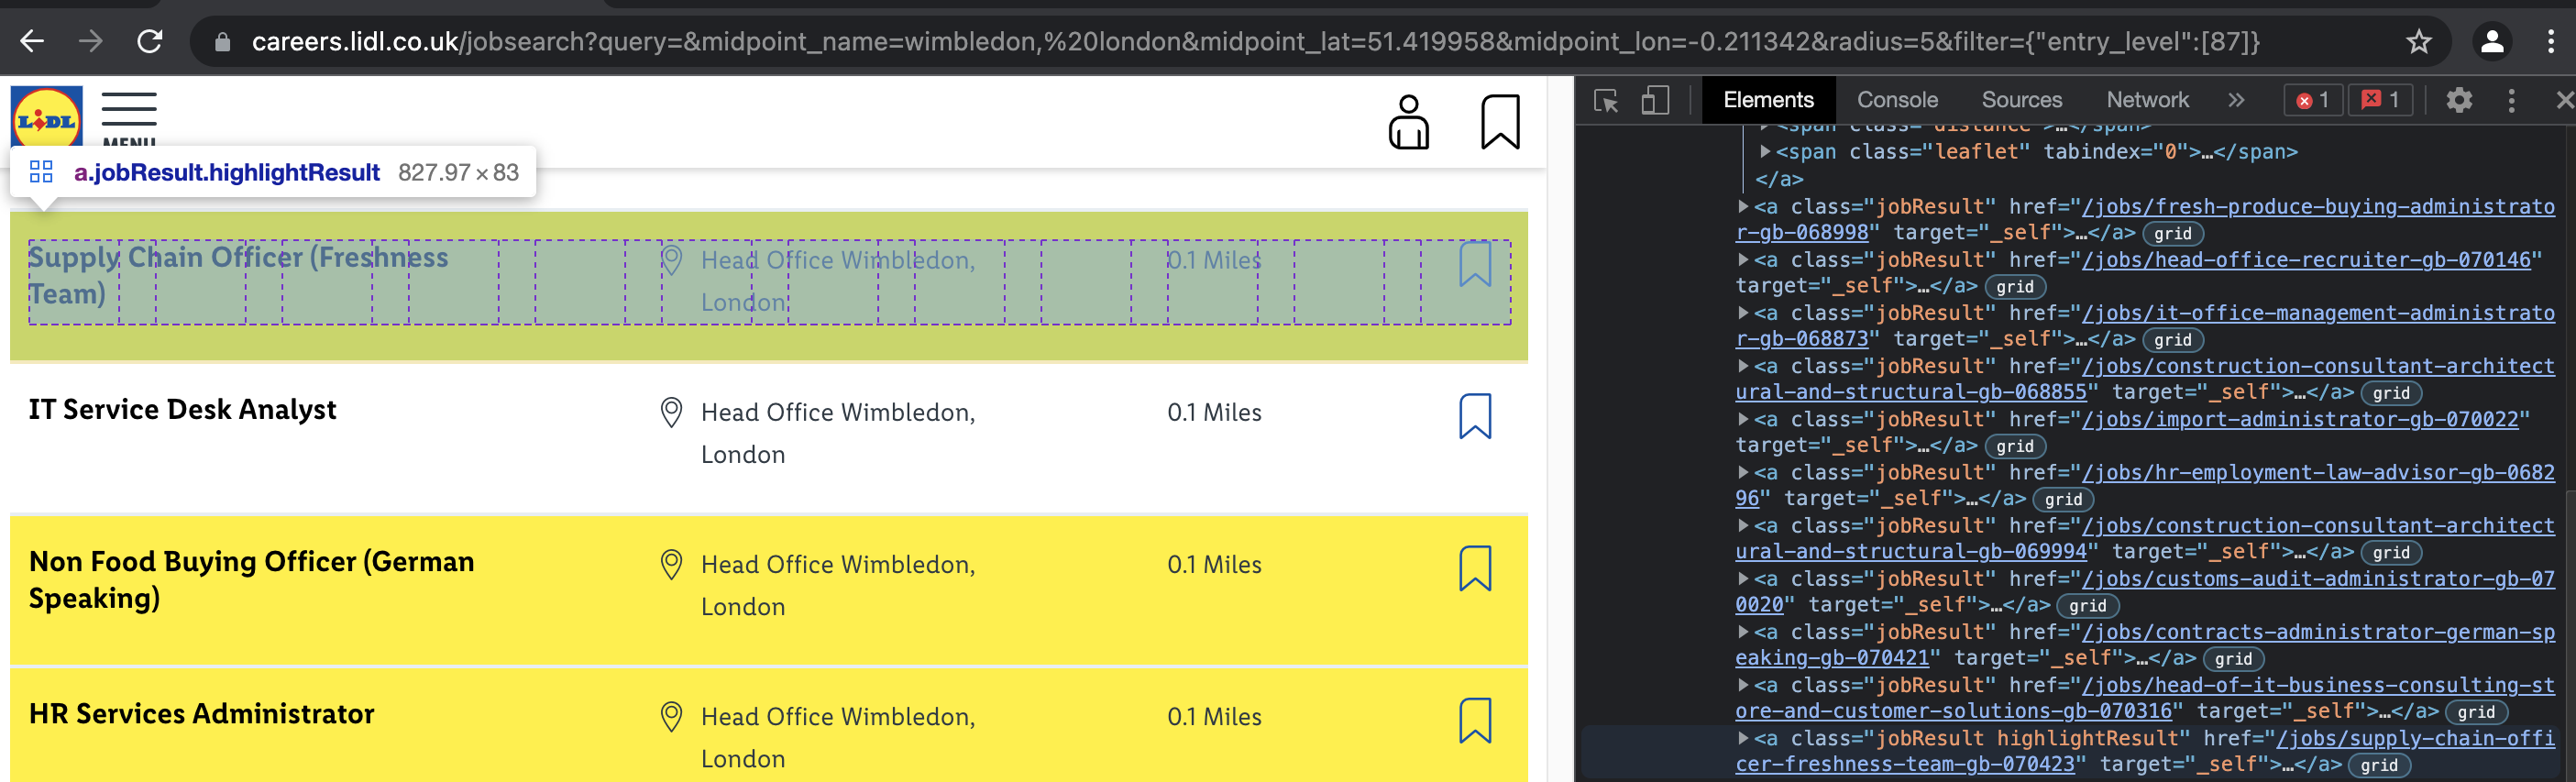

Hence, we again use contains. As we have multiple tags, we now use `find_elements_by_xpath` with plural elements.

In [ ]:
postings = driver.find_elements_by_xpath('//a[contains(@class,"jobResult")]')

We now go through the postings and collect the `href` attribute with `.get_attribute('href')`.

In [ ]:
posting_urls = []
for posting in postings:
    posting_urls.append(posting.get_attribute('href'))
posting_urls

We got (at most) 15 results above. When there are more, postings are spread across multiple pages. Luckily, there is a forward button that let's us scroll through the pages:

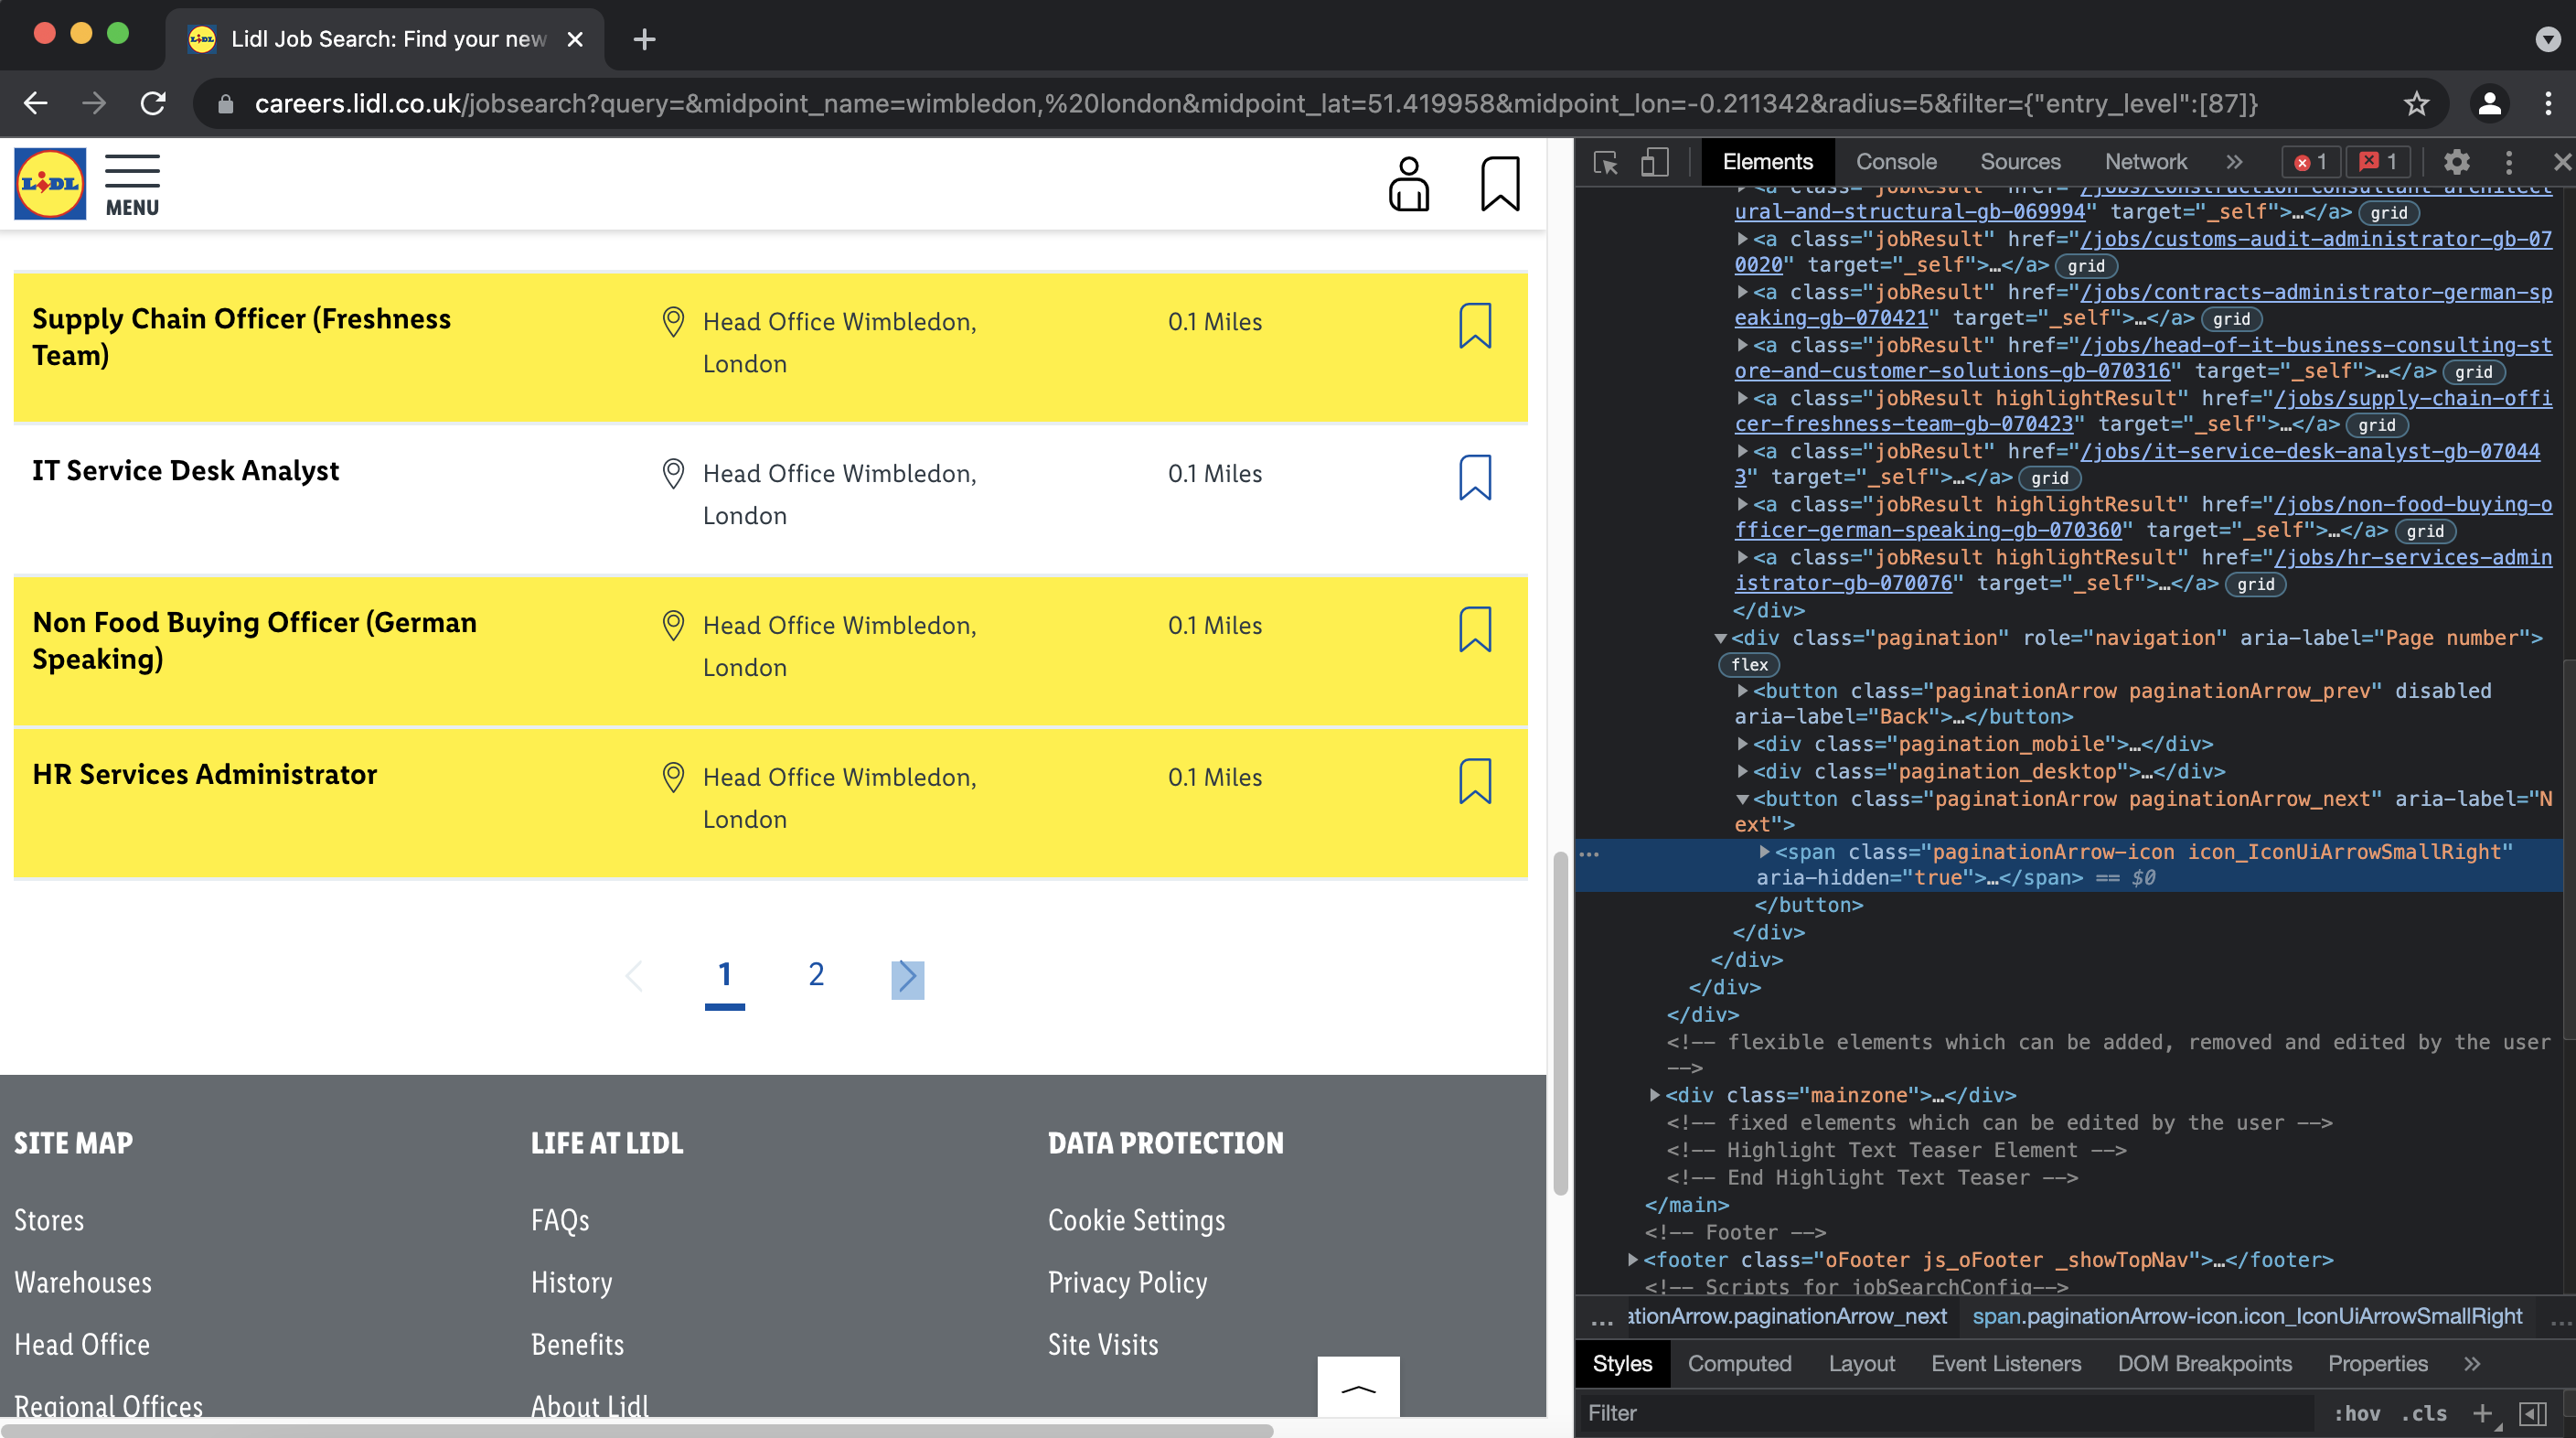


We can combine clicking this button with our previous code. Note that we can only move forward if the next page element actually exists.

Also, we need to make sure to stop when the button is no longer active:

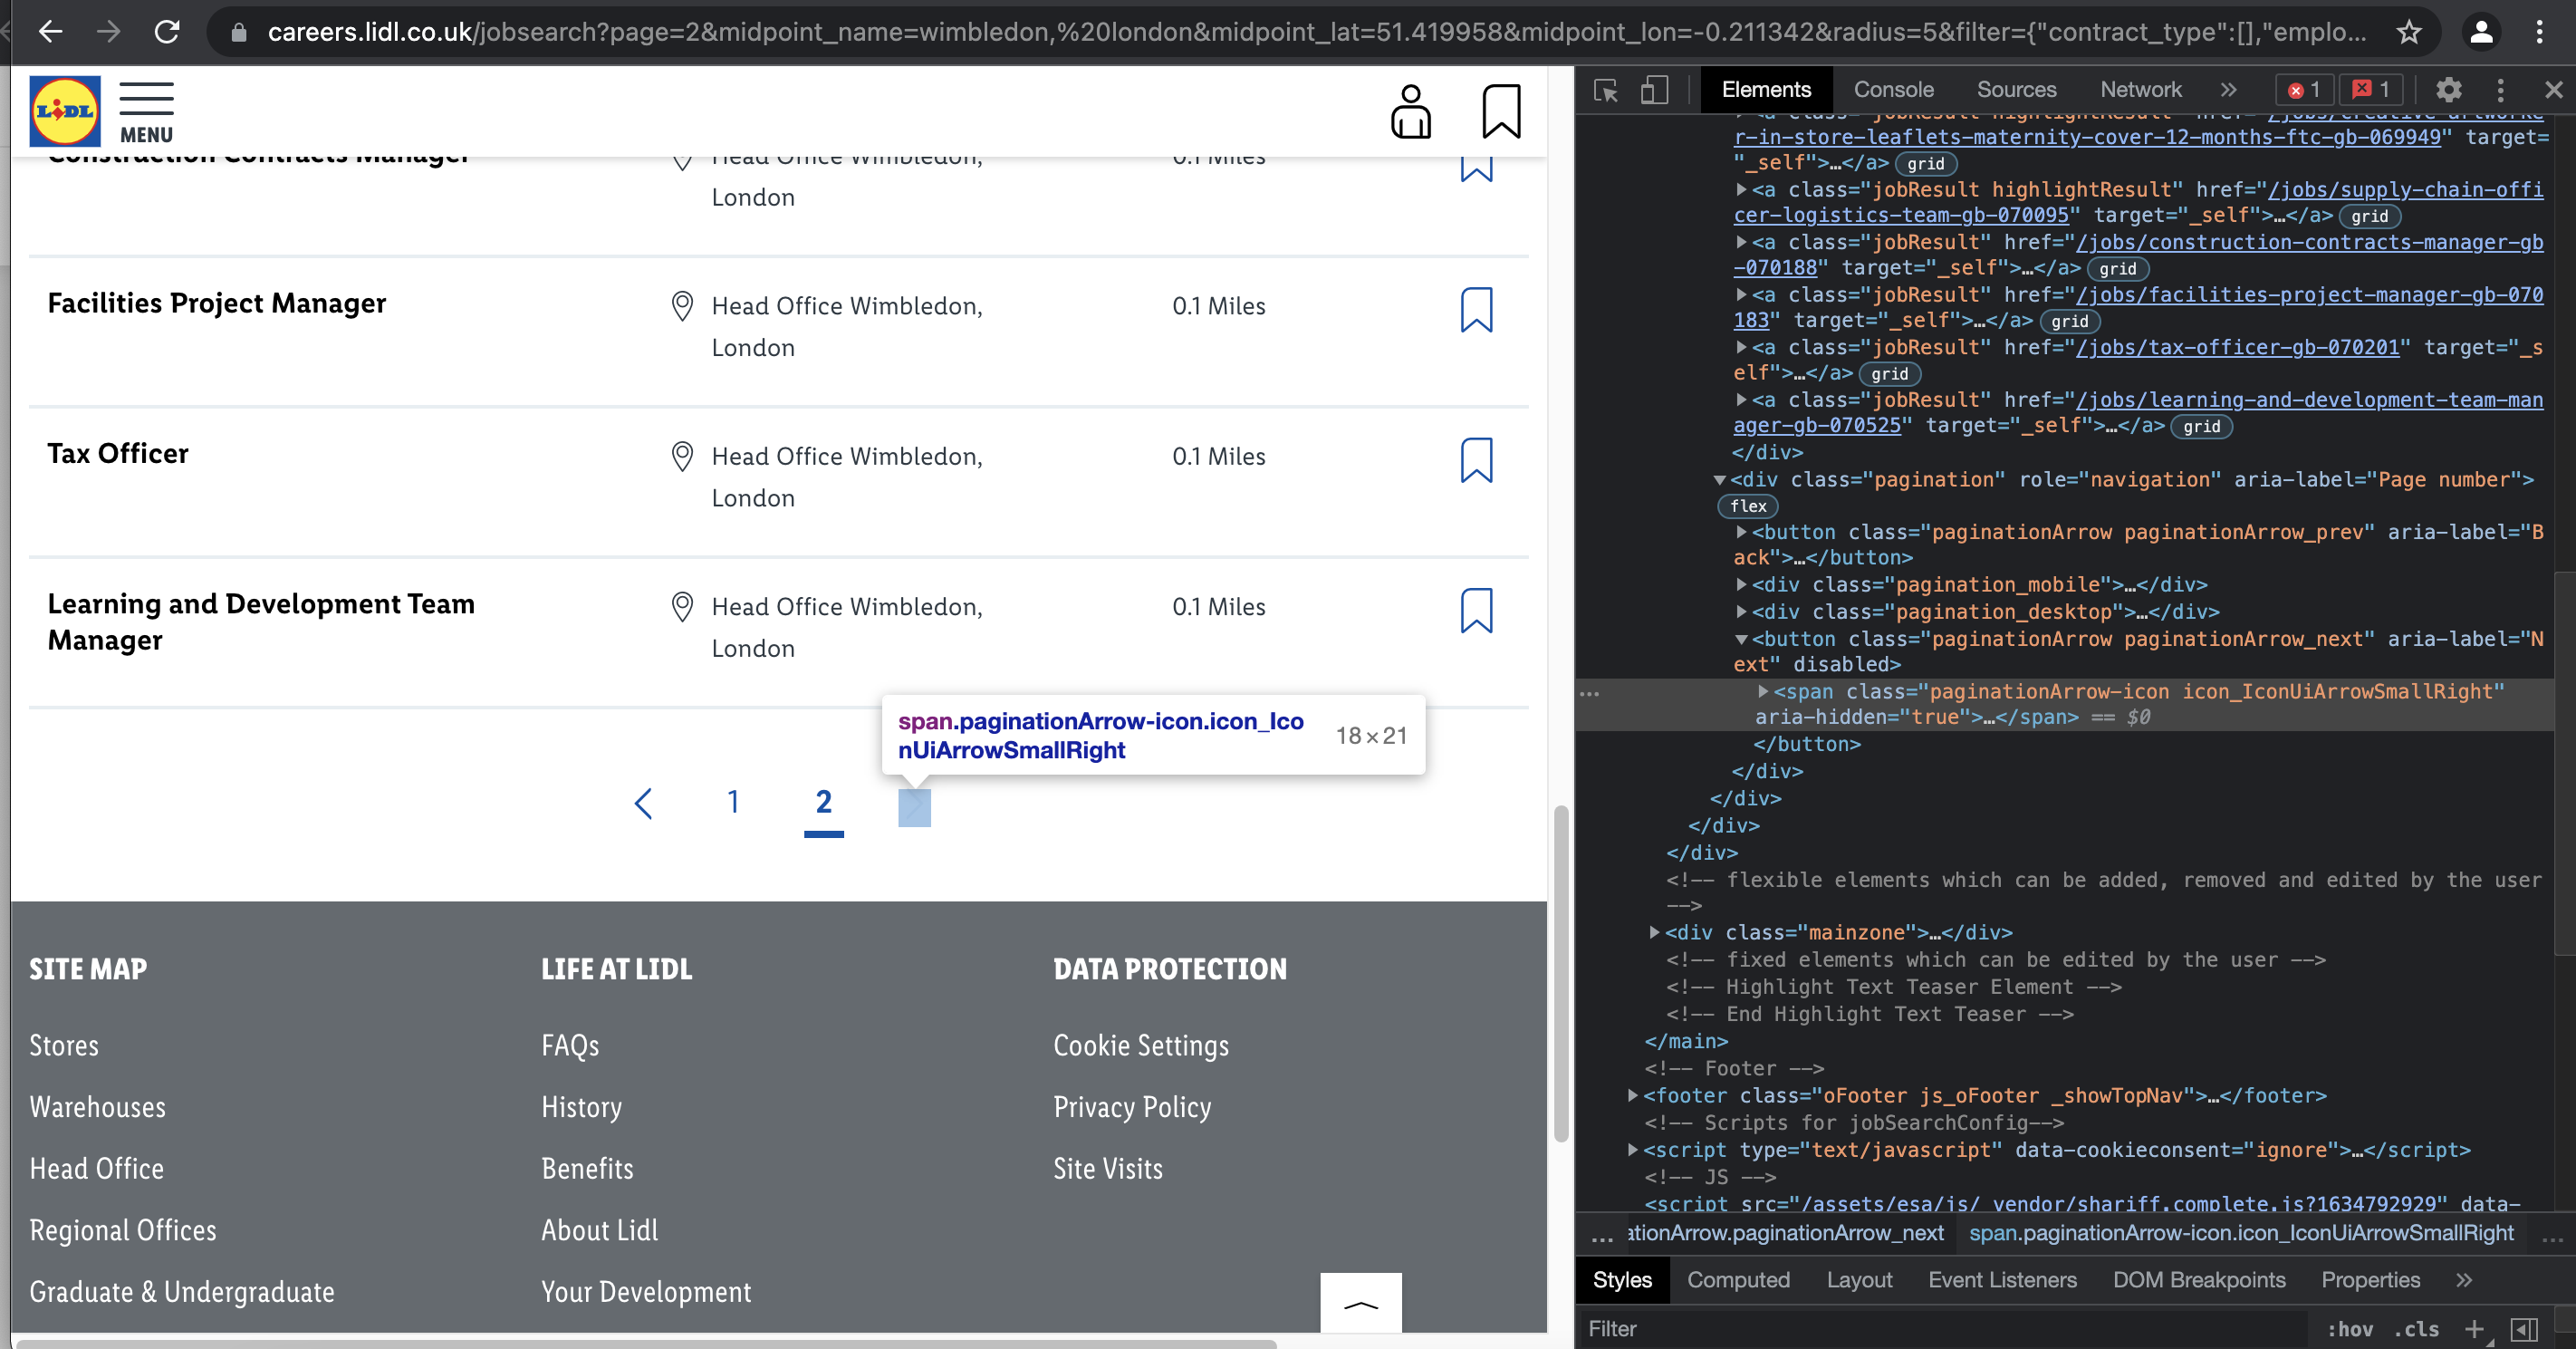

We can find the button using XPath. Make sure to take the right one (the "next" arrow, instead of the "prev" arrow). To find the button, we can use '//button[contains(@class,"paginationArrow_next")]'.

There can be a problem with identifying the button location. Usually, this can be fixed by maximizing the window in which Selenium runs.

In [ ]:
stop = False
posting_urls = []
while not stop:
    driver.implicitly_wait(5)
    postings = driver.find_elements_by_xpath('//a[contains(@class,"jobResult")]')
    print("Found " + str(len(postings)) + " postings")
    for posting in postings:
        posting_urls.append(posting.get_attribute('href'))
    next_elements = driver.find_elements_by_xpath('//button[contains(@class,"paginationArrow_next")]')
    if len(next_elements) > 0:
        element = next_elements[0]
        if element.is_enabled():
            element.click()
            time.sleep(3) # We need to wait a little, as the page takes time to load (try setting the wait to 0 and see what happens!)
        else:
            stop = True
    else:
        stop = True

## Exercise 3

Now that we have loaded the urls of the relevant vacancies, can you extract some key information (e.g., title and postcode of location)? This will be similar to what we did for the Aldi vacancies.

In the below code, we simply access the urls that we have found above (if you are having problems running Selenium, you can find a list of urls on Moodle - be aware that some may no longer exist as job vacancies are dynamic). Let's start with one posting and then see how the extraction works:

In [ ]:
link = posting_urls[0]
# We get the HTML documents
page = requests.get(link)
# We parse the documents with BeautifulSoup
soup = BeautifulSoup(page.content, "html.parser")
# Inspection reveals that titles are within h1-tags with the class given below
title = soup.find("h1", class_="headline_hasBackground").text
print(title)

There is a lot of whitespace here. We can get rid of this with regular expressions:

In [ ]:
title = re.sub('\s+', ' ', title)
print(title)

For the postcode, we can find through inspection that these are in div tags with class "oJobDescription-detailInfo":

In [ ]:
postcode = soup.find("div", class_="oJobDescription-detailInfo").text
print(postcode)

Again, a lot of white space, but what we care about is only the postcode, so we can use regular expressions to find it: '[A-Z]{1,2}[0-9][0-9A-Z]? [0-9][A-Z]{2}'. Let's unpack this. We have one or two capital letters, followed by one number and one number or letter. Then, we have another number, followed by two capital letters. The "?" ensures that we match greedily.

(note: this is a typical case of a regular expression where Google is you friend)

In [ ]:
postcode = re.findall('[A-Z]{1,2}[0-9][0-9A-Z]? [0-9][A-Z]{2}', postcode)[0]
print(postcode)

We can now put things together into a for-loop:

In [ ]:
titles = []
postcodes = []
# We iterate through the URLs, this may take a bit
for link in posting_urls:
    print("Scraping " + link)
    page = requests.get(link)
    soup = BeautifulSoup(page.content, "html.parser")
    title = soup.find("h1", class_="headline_hasBackground").text
    title = re.sub('\s+', ' ', title)
    titles.append(title)
    postcode = soup.find("div", class_="oJobDescription-detailInfo").text
    postcode = re.findall('[A-Z]{1,2}[0-9][0-9A-Z]? [0-9][A-Z]{2}', postcode)[0]
    postcodes.append(postcode)

job_data = pd.DataFrame(
    {'Title': titles,
     'Postcode': postcodes
    })
job_data

# 2. Basics of classes

Let's start by defining the class `Car`. No matter the car, it will have a make, a model, a number of horsepowers, and a (maximum) speed. So we can use these attributes to define objects of our class:

In [ ]:
class Car():
    def __init__(self,make, model, hp, speed):
        self.make = make
        self.model = model
        self.hp = hp
        self.speed = speed

We can now define an object, for example, a Toyota Camry with 100 horse power and a maximum speed of 120 (miles/hour)

In [ ]:
car1 = Car("Toyota","Camry",100,120)

When coding, we often print out "things", at the very least to debug. Let's see what happens when we print out our object:

In [ ]:
print(car1)

To adjust how an object is represented as a string, we (re)define the `__str__` method:

In [ ]:
class Car():
    def __init__(self,make, model, hp, speed):
        self.make = make
        self.model = model
        self.hp = hp
        self.speed = speed
    def __str__(self):
        return "Make: " + self.make + ", Model: " + self.model + ", Horse Power: " + str(self.hp) + ", Speed: " + str(self.speed)

Now we should get something more descriptive:

In [ ]:
car2 = Car("Toyota","Camry",100,120)
print(car1)

Note that a string method *should* be unique to the specific object. If we have two `Car` objects that are different, they should also return a different string.

We can also access the attributes of our `Car` objects:

In [ ]:
print(car2.speed)

And, since we can access the attributes, we can also set them to different values:

In [ ]:
car2.speed = 130

In [ ]:
print(car2.speed)

However, you should not change objects like this (because you may be changing things that the developer of the class doesn't want you to change, so that the code can continue running smoothly). Commonly, if you can safely change an object's attribute, there will be a "setter" method to do so. In this method, the developer may add in some safety checks to ensure your change is valid. Also, you should be using "getter" methods to call up attributes.

In [ ]:
class Car():
    def __init__(self,make, model, hp, speed):
        self.make = make
        self.model = model
        self.hp = hp
        self.speed = speed
    def __str__(self):
        return "Make: " + self.make + ", Model: " + self.model + ", Horse Power: " + str(self.hp) + ", Speed: " + str(self.speed)
    def set_speed(self,speed):
        if speed > 0:
            self.speed = speed
        else:
            print("invalid speed")
    def get_speed(self):
        return self.speed

Let's create another car

In [ ]:
car3 = Car("Toyota","Camry",100,120)

Now, try to set the speed to something invalid: this will not work (rightly so!)

In [ ]:
car3.set_speed(-10)

We can confirm that nothing changed, by either calling the attribute directly (not recommended), or calling the "getter" method (recommended):

In [ ]:
print(car3.get_speed())

By directly accessing the `speed` attribute, however, we can set it to something invalid:

In [ ]:
car3.speed = -10

In fact, the maximum speed is now negative!

In [ ]:
print(car3.get_speed())

Let's correct this - with the "setter" method:

In [ ]:
car3.set_speed(130)

Finally, we check again, using the "getter" method:

In [ ]:
print(car3.get_speed())

We can also use our objects as input to a method. For example, let's see whether our `Car` object is fast:

In [ ]:
def is_car_fast(car):
    if car.get_speed() > 130:
        return True
    else:
        return False

In [ ]:
print(is_car_fast(car3))

An important part of object-oriented programming is the ability to inherit. For example, just as we can make `Car` objects, we can make `Ford` objects. But any `Ford` is also a `Car`! In Python, inheritance is marked by adding another class as parameter to the class we are programming:

In [ ]:
class Ford(Car):
    def __init__(self, model, hp, speed):
        Car.__init__(self, "Ford", model, hp, speed)

In our case above, when we create a `Ford`, we create a `Car` with `"Ford"` as the make. Le'ts try it out:

In [ ]:
ford1 = Ford("Focus",80,110)

In [ ]:
print(ford1)

## Exercise 4

Define a class `Person`, as follows:
1. define an `__init__` method that takes a name and an age as argument and set the corresponding object-attributes
2. define a `get_name` method that returns the name of the `Person`-object

In [ ]:
class Person():
    def __init__(self,name,age):
        self.name = name
        self.age = age
    def get_name(self):
        return self.name

Next, define a class `Organization`:
1. the class should have an `__init__` method, in which an empty object-specific list `hires` gets created
2. the class should also have a `hire` method that takes a `Person` as an input and adds the person to the list of hires
3. finally, the class should have a `__str__` method that returns a string including all the names of the hires

In [ ]:
class Organization():
    def __init__(self):
        self.hires = []
    def __str__(self):
        names = ''
        for person in self.hires:
            names = names + person.get_name() + ", "
        return 'An organization consisting of ' + names
    def hire(self, person):
        self.hires.append(person)

Create two persons with name and age. Then, create an organization, hire the two person, and run `print` on the organization:

In [ ]:
person1 = Person("Sharon", 46)
person2 = Person("Maisie", 22)
orga1 = Organization()
orga1.hire(person1)
orga1.hire(person2)
print(orga1)

# 3. Scrapy

We now turn to `scrapy`. As always, there is a package to import (and install, if you haven't done so already):

In [ ]:
import scrapy

We create a spider (which inherits from the `scrapy.Spider`), which starts with two subpages of http://quotes.toscrape.com/. Every time our spider parses a webpage, it simply saves the entire HTML document locally:

In [ ]:
class QuotesSpider(scrapy.Spider):
    name = "quotes"

    start_urls = [
        'http://quotes.toscrape.com/page/1/',
        'http://quotes.toscrape.com/page/2/',
    ]

    def parse(self, response):
        page = response.url.split("/")[-2]
        filename = f'quotes-page{page}.html'
        with open(filename, 'wb') as f:
            f.write(response.body)
        self.log(f'Saved file {filename}')

Usually, we run spiders from the terminal (we will see how to do this later). However, we can run the spider from a Jupyter notebook - once:

In [ ]:
from scrapy.crawler import CrawlerProcess

In [ ]:
process = CrawlerProcess()
process.crawl(QuotesSpider)
process.start()

But try doing this again (without restarting the kernel), and you are likely to run into problems. There are, in principle, ways around this, but they are quite tedious. So let's take a look at running `scrapy` from the terminal.